In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

## User parameter setup

List of all background files to use. Data loading function will find associated data files in the same directory as backgrounds.

In [3]:
background_fps = ['/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_05_StoberRandomCampaignV2/03210_B9-T1_Ethanol_background__000.dat',
                  '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_07_randomcampaignV3/data/03218_D1-T1_Ethanol_background_1_000.dat',
                  '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_11_randomV3_round2/03289_H6-T2_EtOH_background_1_000.dat',
                  '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_10_17_randomBaselineV4/data/03439_C1-T2_EtOH_1_000.dat',
                  '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_12_16_OptCompare_80nmtarget_Round1/03818_E6-T2_Ethanol_1_000.dat',
                  '/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/Stober_synthesis/SAXS_data/2024_12_19_OptCompare_80nmtarget_Round2/03861_D5-T2_Ethanol_1_000.dat']

Select q ranges. Right now this relies on manual q range selection to a certain extent. We subtract background and fit the spline on a larger q-range, then evaluate the spline on a subset of the larger q range to avoid spline edge effects.

In [4]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

Select target particle parameters. Target is spherical particles with radius r and polydispersity pdi

In [5]:
target_r_nm = 40
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

Set processing and optimization parameters for distance calculation

In [6]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

## ######################## STOP: Don't touch anything below here \#############################


## Load data

In [7]:
sample_data, uuid2bkg, data_fps = io.load_biocube_data_with_background(background_fps, 24)

In [9]:
len(data_fps)

160

## Calculate target scattering

In [10]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

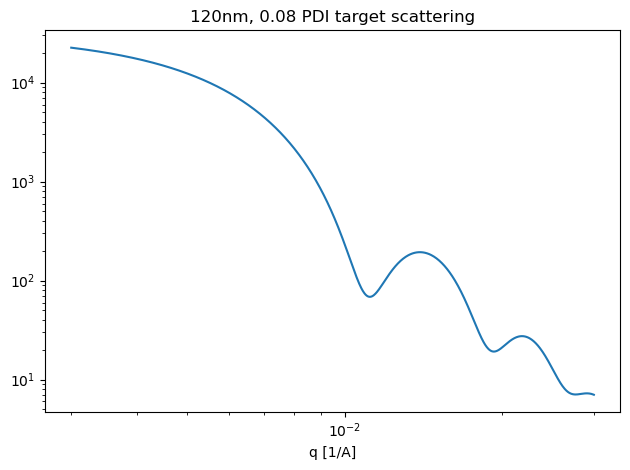

In [11]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')
ax.set_title('120nm, 0.08 PDI target scattering')
plt.tight_layout()
plt.savefig('target_profile_120nm.png', dpi = 300)

## Run full processing pipeline

In [12]:
processing_dataset = {}
counter = 0
for uuid_val, data_val in sample_data.items():
    if uuid_val == 'cd55dfb0-6366-43ea-a2a7-14679305116c':
        print(f'{counter}: {uuid_val}')
        counter += 1
        meas_entry = {}
        meas_entry['original_data'] = data_val[0]
        background = uuid2bkg[uuid_val]
        meas_entry['background'] = background[0]
        # 1. Subtract background and select q range
        subtracted = subtract.chop_subtract(data_val[0], background[0], hiq_thresh=1)
        
        if subtracted is None:
            # if subtract returned None, data has issues and we are done with this sample
            meas_entry['status'] = 'failed'
            meas_entry['failure_point'] = 'background_subtraction'
            processing_dataset[uuid_val] = meas_entry
            print(f'Sample {uuid_val} failed at background subtraction')
            continue
            
        else:
            # q range selection
            subtracted = subtracted[subtracted['q'] < q_max_subtract]
            subtracted = subtracted[~subtracted['I'].isna()]
            subtracted = subtracted[subtracted['I'] > 0] # drop negative values 
            # screen on dataset length
            if len(subtracted) < min_data_len:
                meas_entry['status'] = 'failed'
                meas_entry['failure_point'] = 'subtracted_data_length'
                processing_dataset[uuid_val] = meas_entry
                print(f'Sample {uuid_val} failed due to data length')
                continue
            else:
                meas_entry['subtracted_clipped'] = subtracted
                meas_entry['status'] = 'valid'
                processing_dataset[uuid_val] = meas_entry
    
    
        # 2. Convert everything into log10 space
        q_log = np.log10(subtracted['q'].to_numpy())
        I_log = np.log10(subtracted['I'].to_numpy())
    
        meas_entry['q_log'] = q_log
        meas_entry['I_log'] = I_log
        
        # 3. denoise filter on intensity
        
        I_savgol = manipulate.denoise_intensity(I_log, savgol_n = savgol_n, savgol_order = savgol_order)
    
        meas_entry['I_savgol'] = I_savgol
    
        # 4. Spline fit and interpolate
        I_spline = manipulate.fit_interpolate_spline(q_log, I_savgol, q_grid, s = s, k = k)
        
        meas_entry['I_spline'] = I_spline
    
        # 5. scale onto target
        I_scaled = manipulate.scale_intensity_highqavg(I_spline, target_I, n_avg = n_avg)
    
        meas_entry['I_scaled'] = I_scaled
    
        #6. Calculate AP distance
    
        amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)
    
        ap_sum = amplitude + phase
    
        meas_entry['amplitude_distance'] = amplitude
        meas_entry['phase_distance'] = phase
        meas_entry['ap_sum_distance'] = ap_sum
    
    
        ## calculate raw RMSE
        meas_df = pd.DataFrame({'q':10**q_grid, 'I':10**I_scaled, 'sig':np.zeros(len(I_scaled))})
        #target_df = pd.DataFrame({'q':10**q_grid, 'I':10**target_I, 'sig':np.zeros(len(target_I))})
        
        raw_rmse = target_comparison.rmse_distance(I_scaled, target_I, log = False) # these intensities are already in log
        screened_rmse = target_comparison.calculate_distance_powerlawscreen(subtracted, meas_df, 10**target_I)
    
        meas_entry['rmse_raw'] = raw_rmse
        processing_dataset[uuid_val] = meas_entry
        

0: cd55dfb0-6366-43ea-a2a7-14679305116c


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


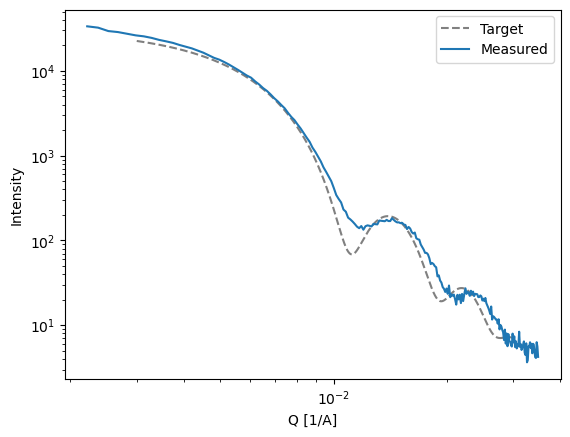

In [16]:
I_sub = processing_dataset['cd55dfb0-6366-43ea-a2a7-14679305116c']['I_log']
q = processing_dataset['cd55dfb0-6366-43ea-a2a7-14679305116c']['q_log']
scale = 1.75

fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I, ls = '--', color = 'gray', label = 'Target')
ax.loglog(10**q_log, 10**scale*10**I_sub, label = 'Measured')
ax.legend()
ax.set_xlabel('Q [1/A]')
ax.set_ylabel('Intensity')
plt.savefig('80nmexamplar_cd55dfb0-6366-43ea-a2a7-14679305116c.png', dpi = 300)

### Sanity check subtraction

In [ ]:
for uuid_val, entry in processing_dataset.items():
    print(uuid_val)
    try:
        status = entry['status']
        if status == 'failed':
            print('failed at ', entry['failure_point'])
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']
    
        ax.scatter(q, I_subtracted)
        ax.set_title(uuid_val)

## Sanity check spline fit

In [ ]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()
    
        I_subtracted = entry['I_log']
        q = entry['q_log']

        I_spline = entry['I_spline']
        
    
        ax.scatter(q, I_subtracted, label = 'subtracted')
        ax.scatter(q_grid, I_spline, label = 'Spline')
        ax.legend()
        ax.set_title(uuid_val)

## Sanity check scaling

/tmp/ipykernel_14143/1900914898.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


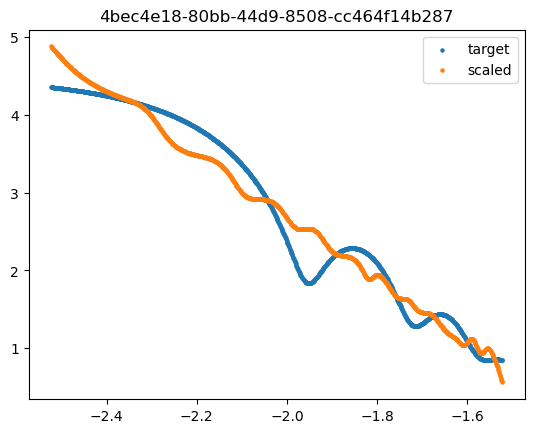

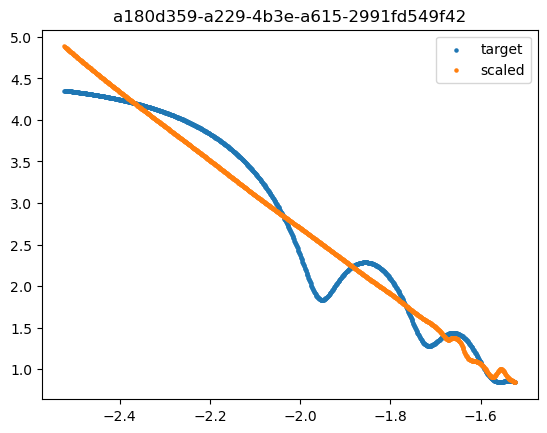

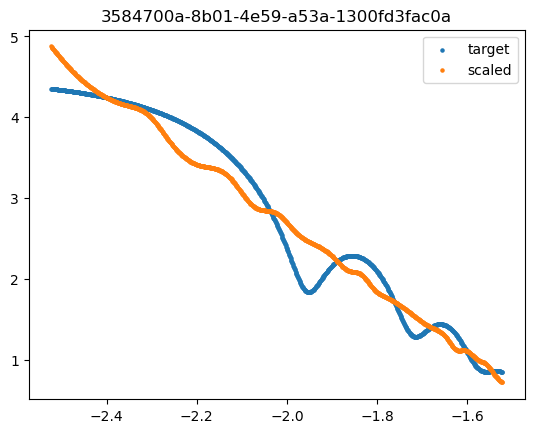

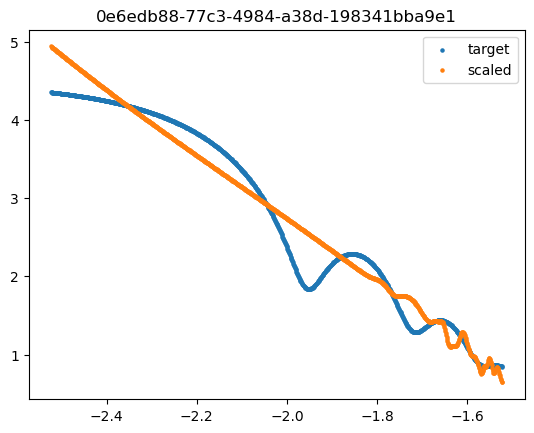

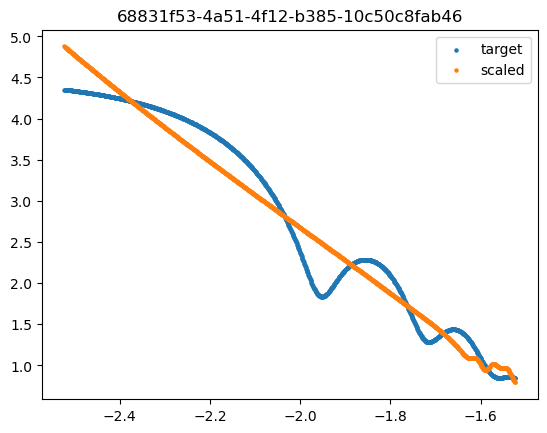

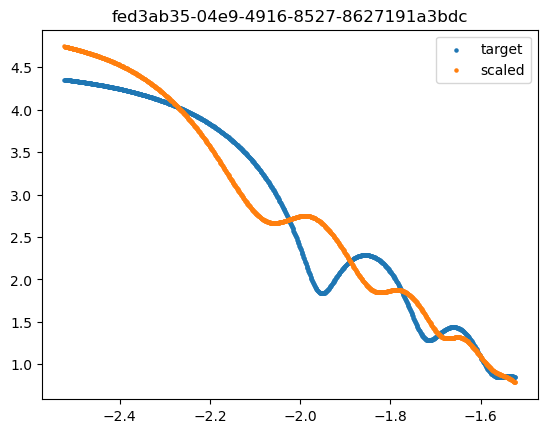

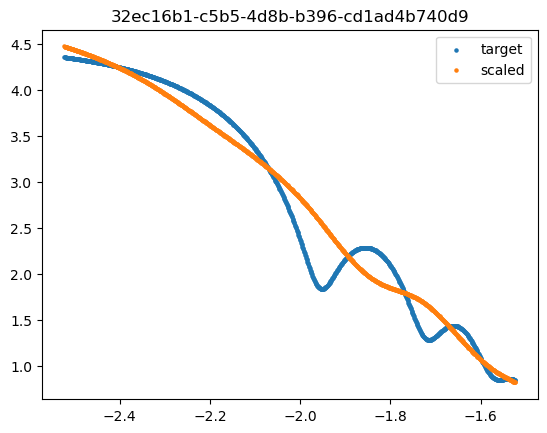

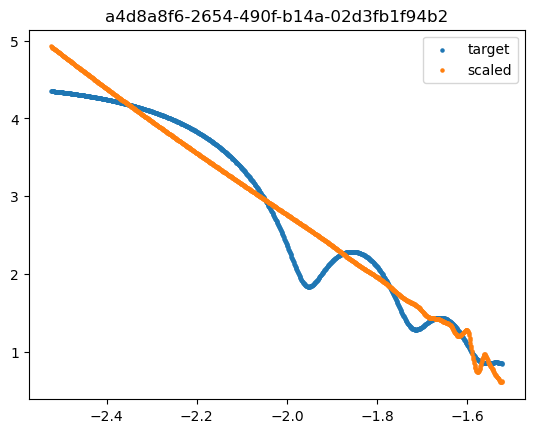

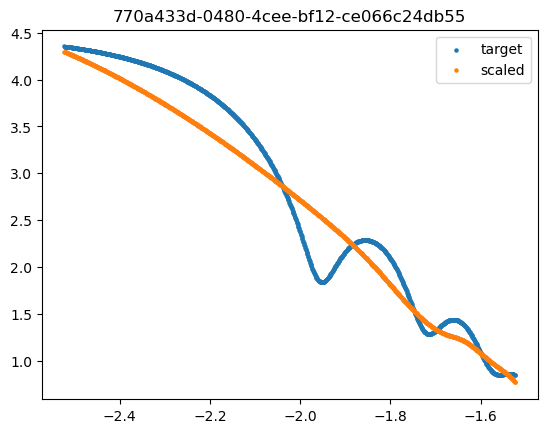

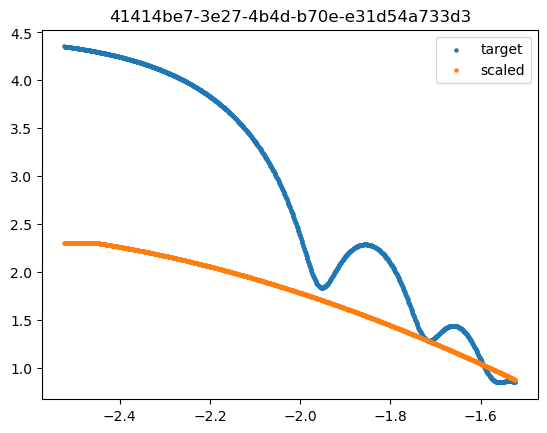

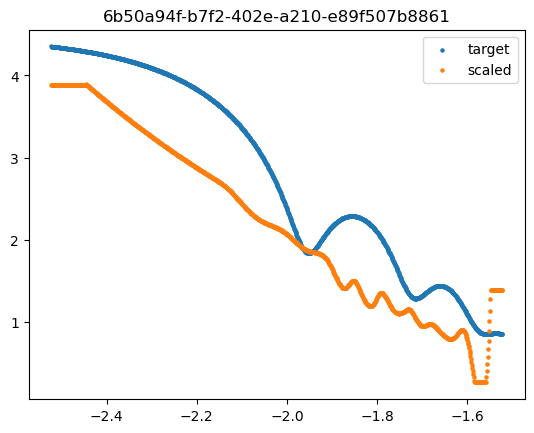

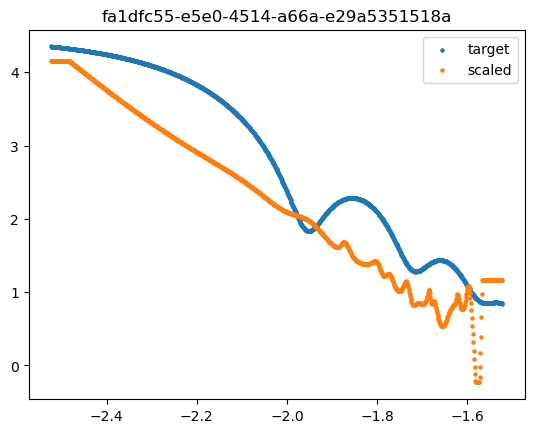

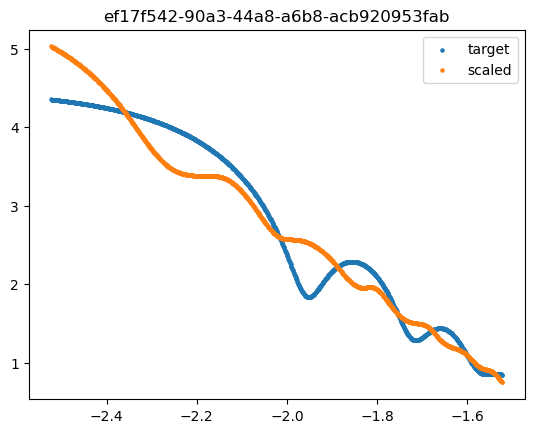

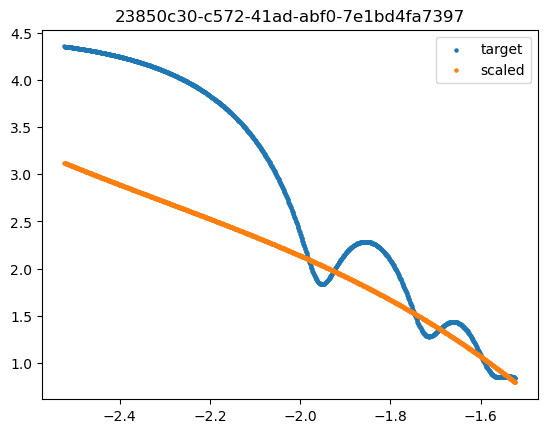

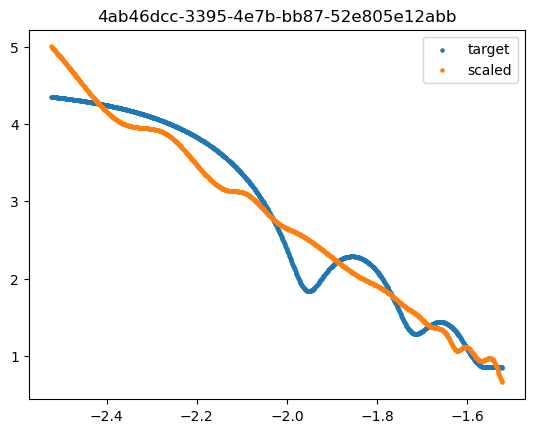

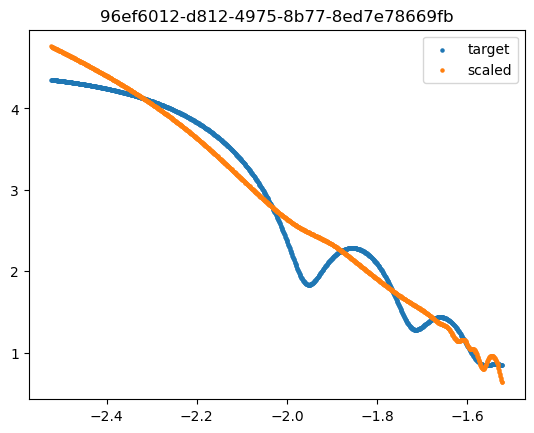

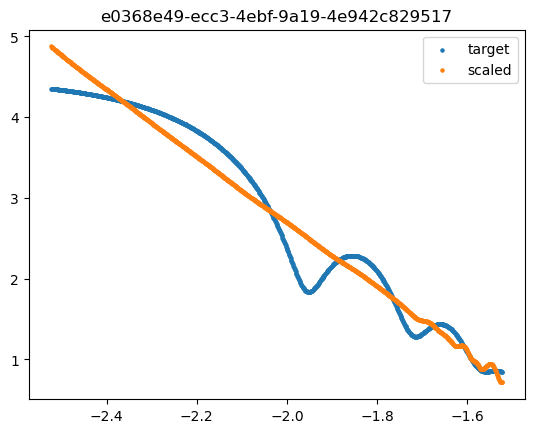

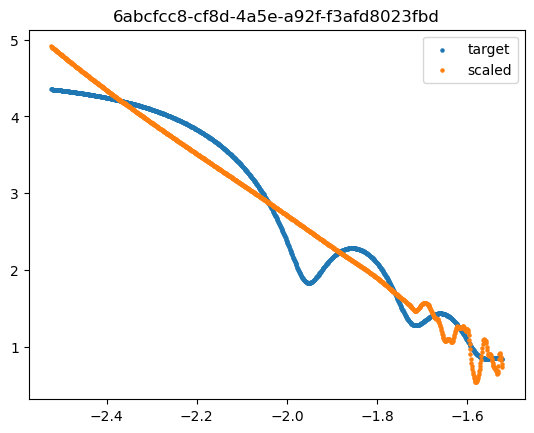

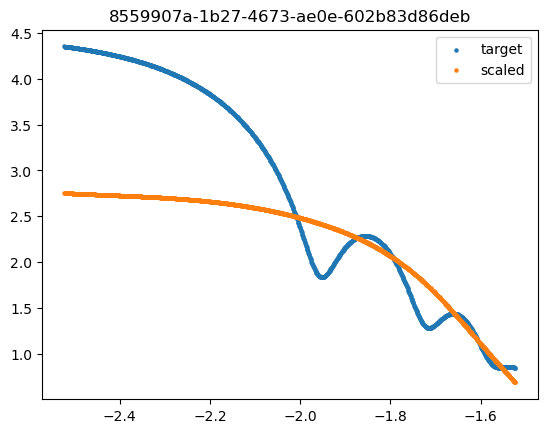

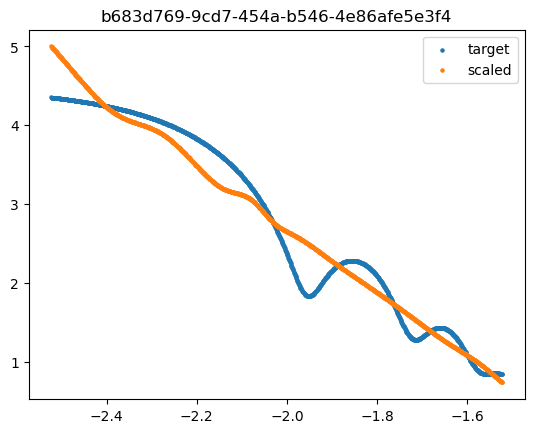

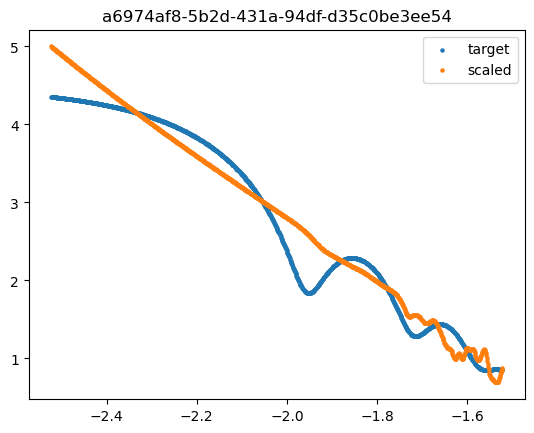

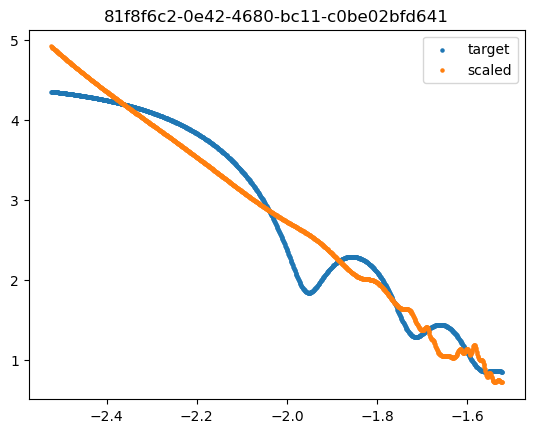

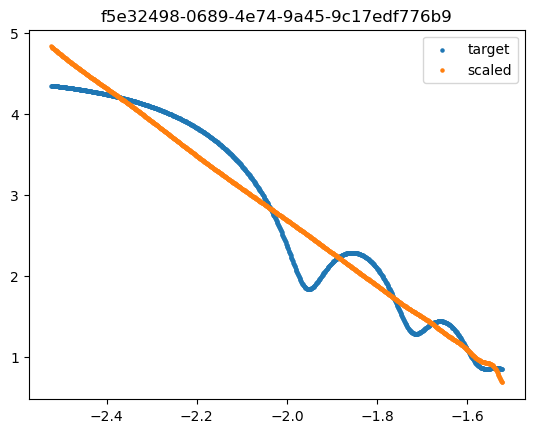

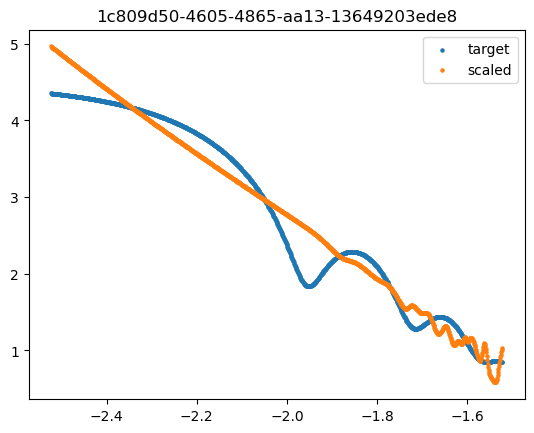

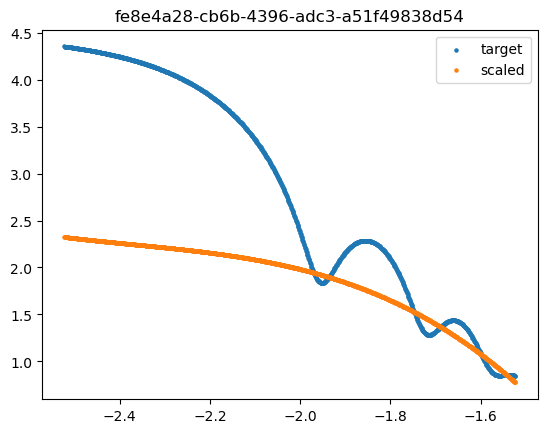

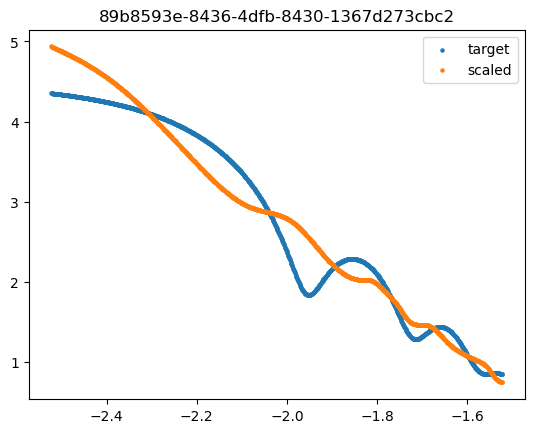

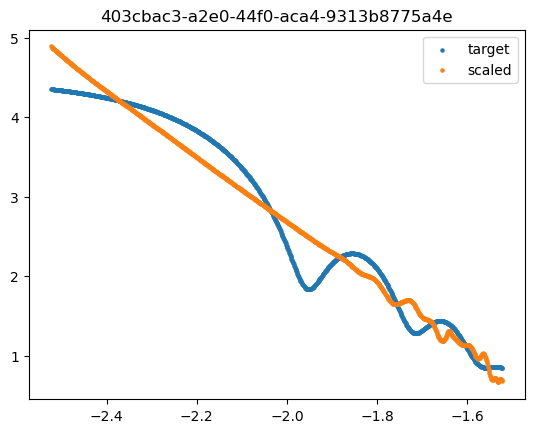

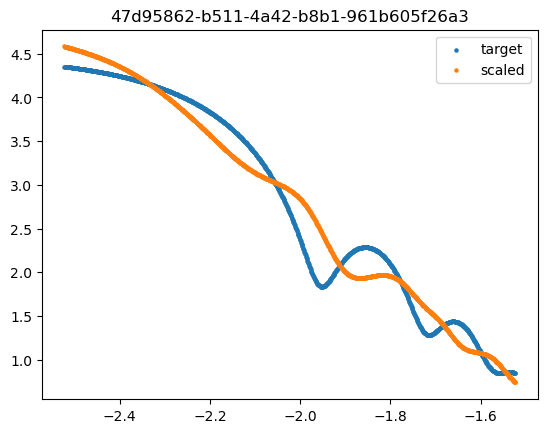

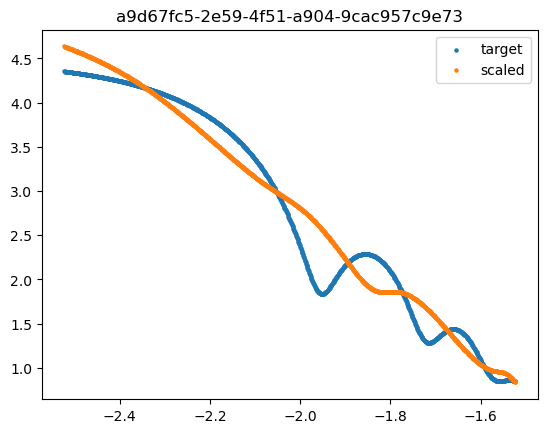

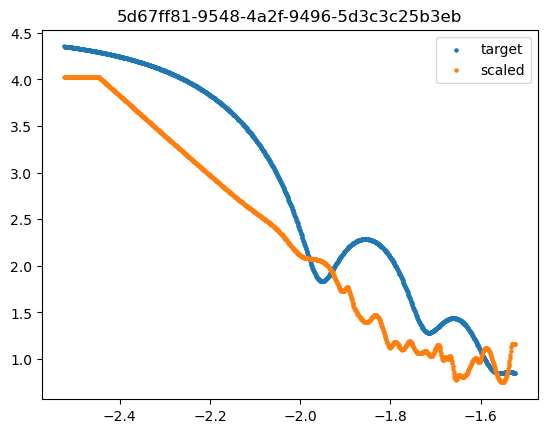

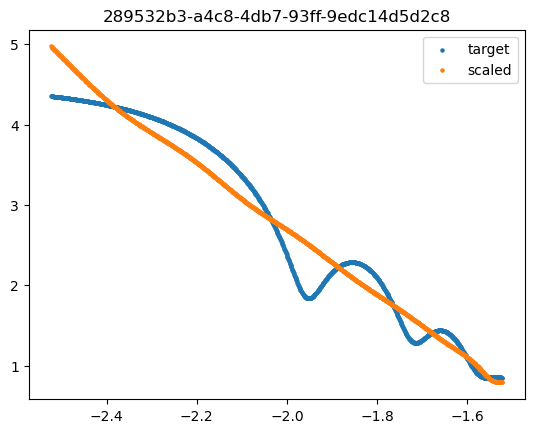

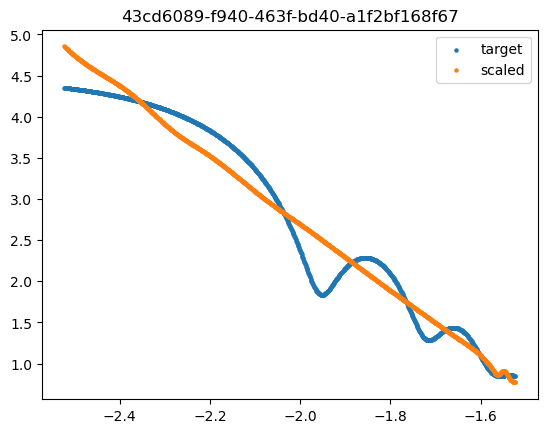

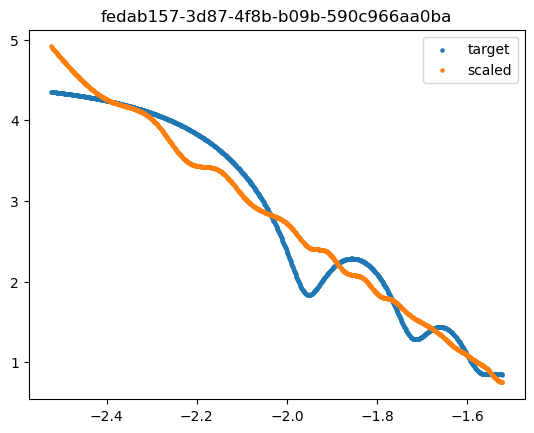

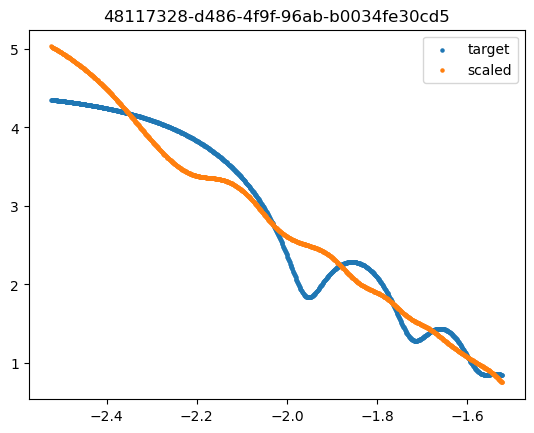

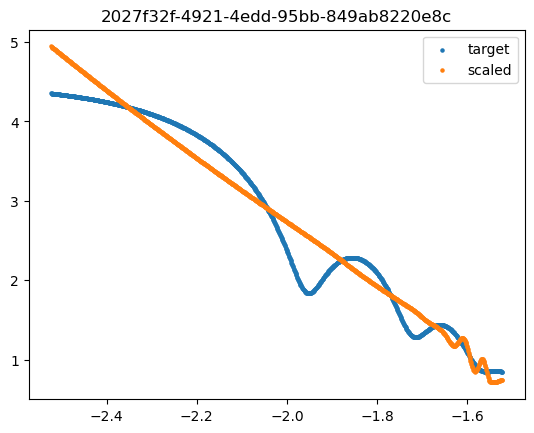

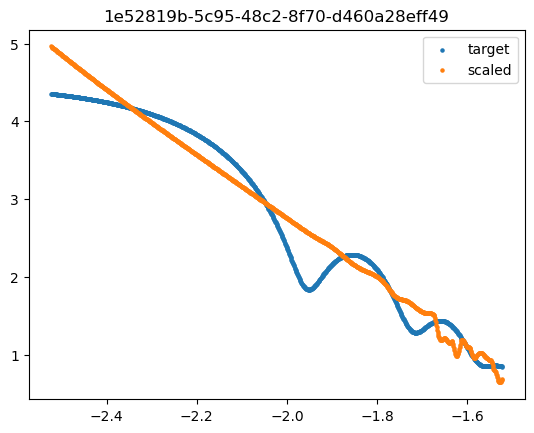

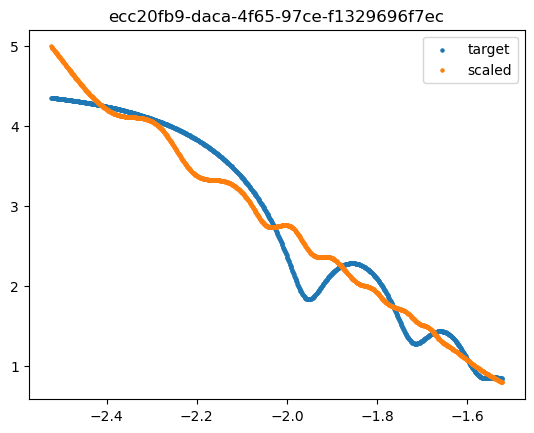

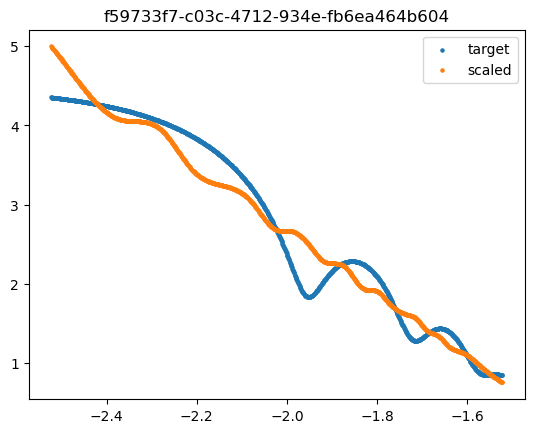

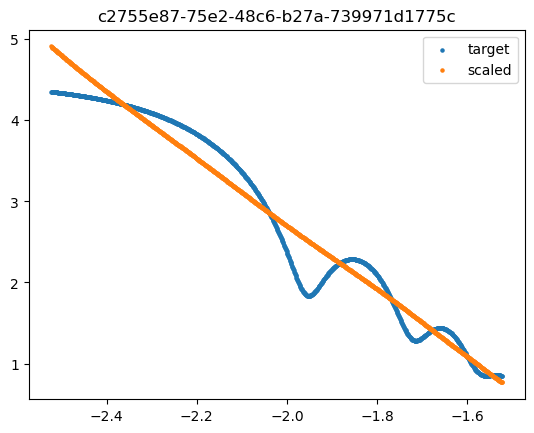

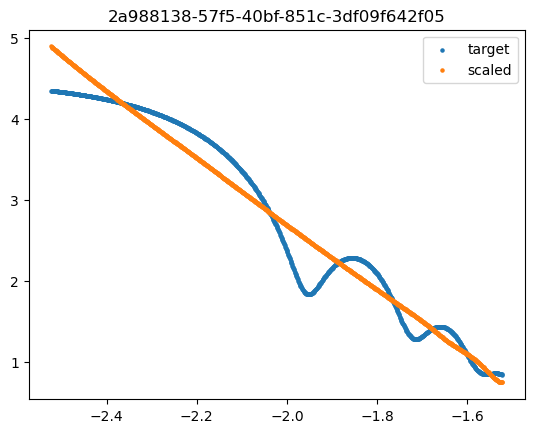

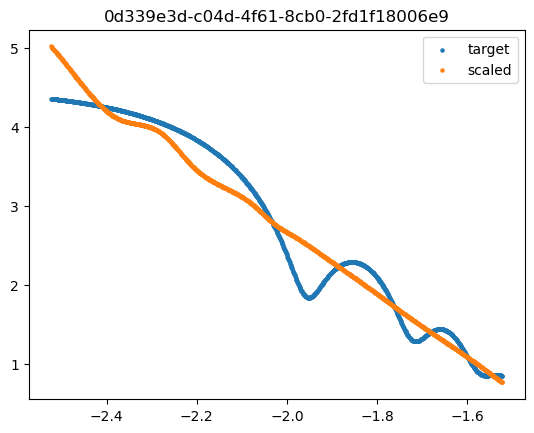

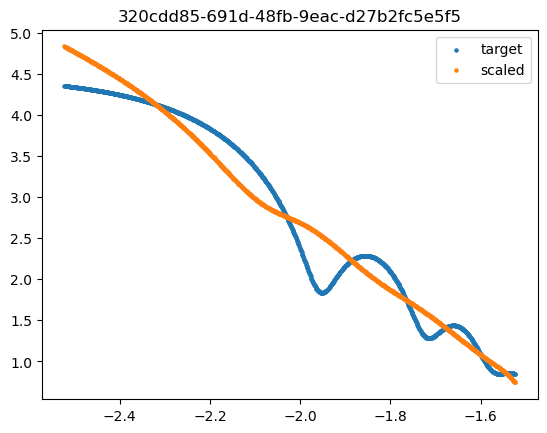

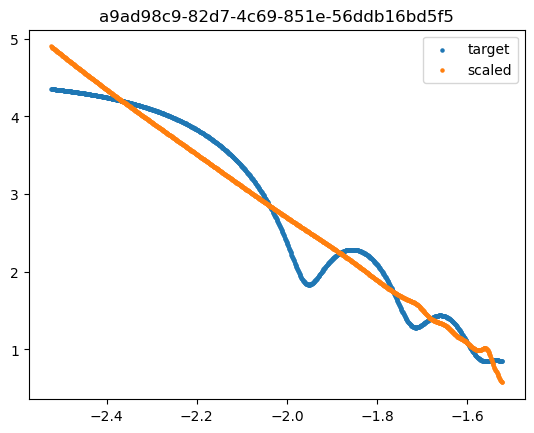

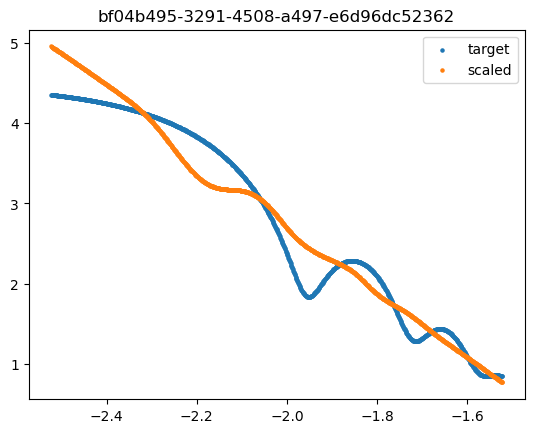

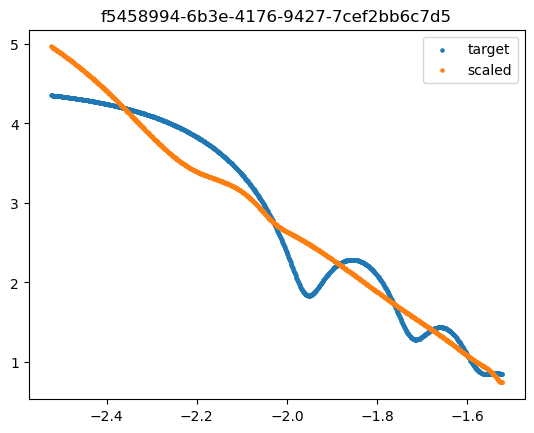

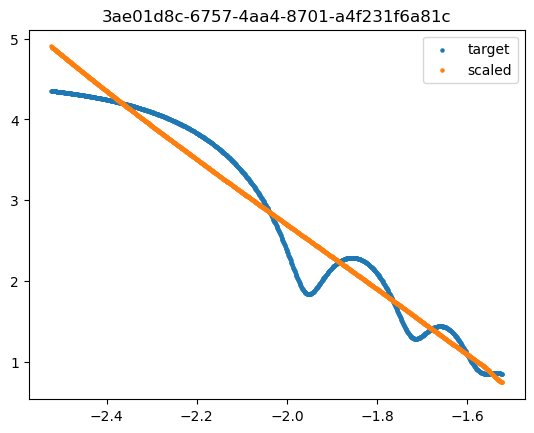

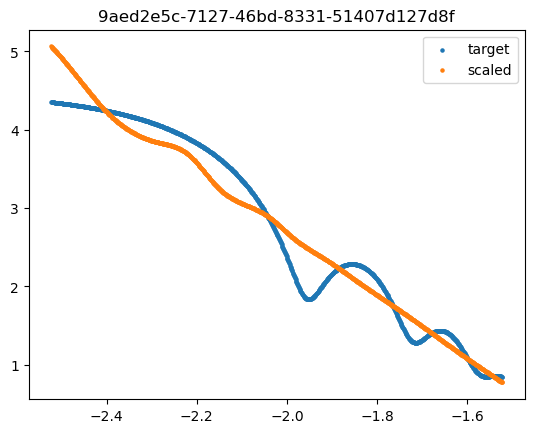

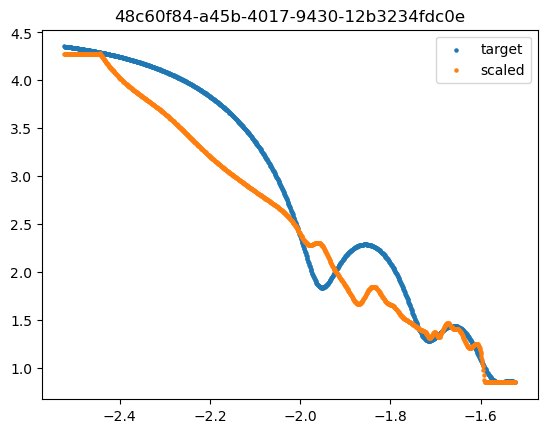

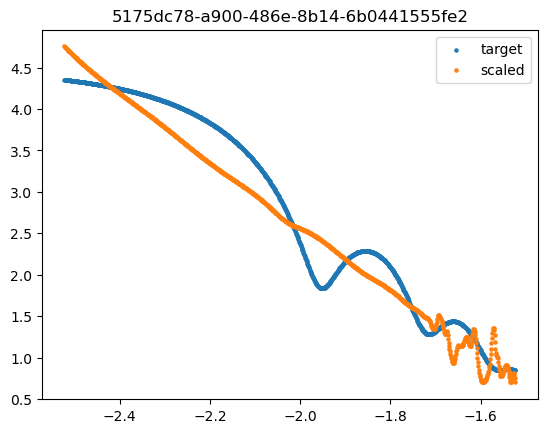

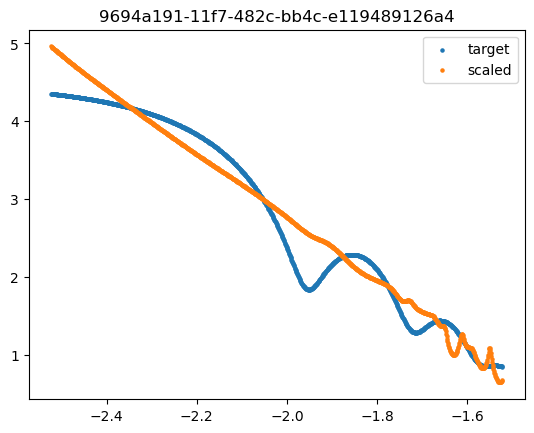

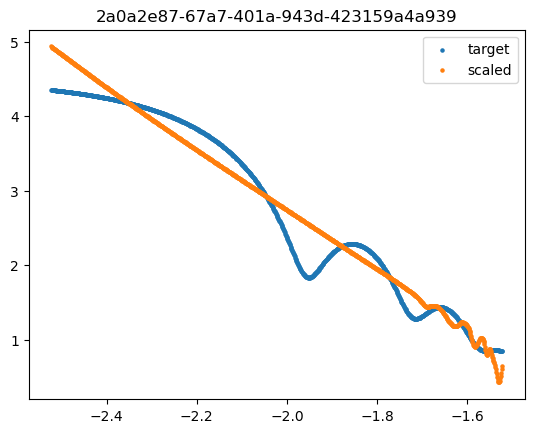

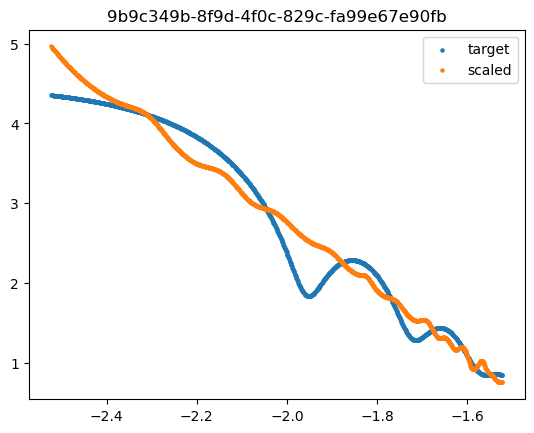

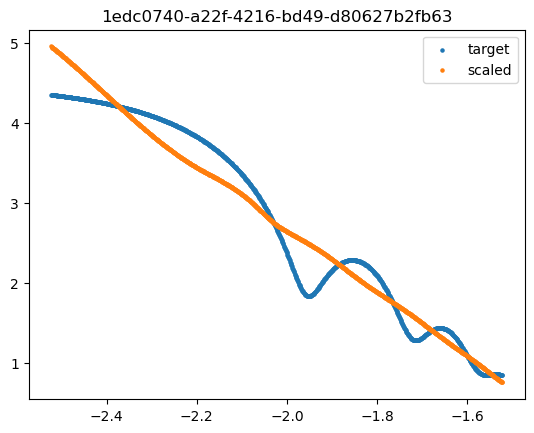

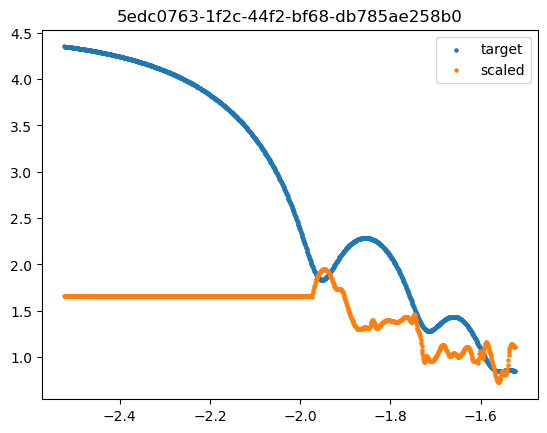

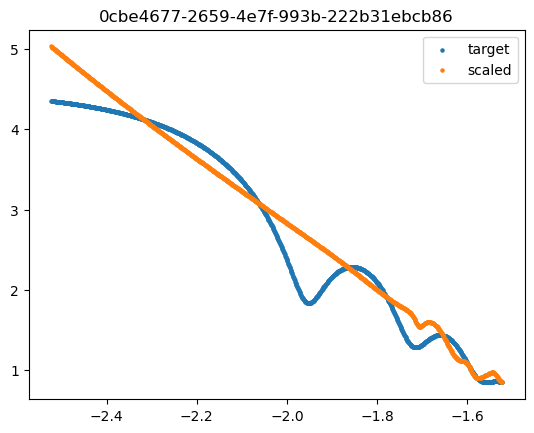

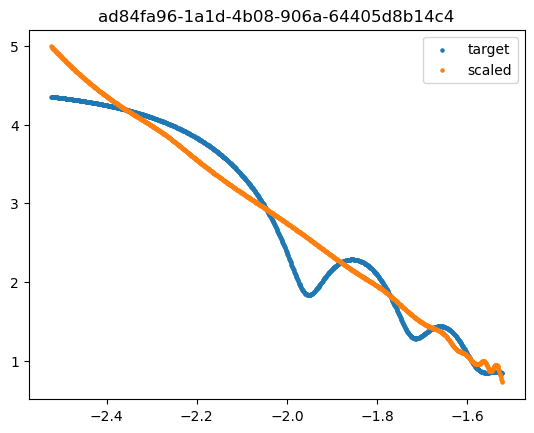

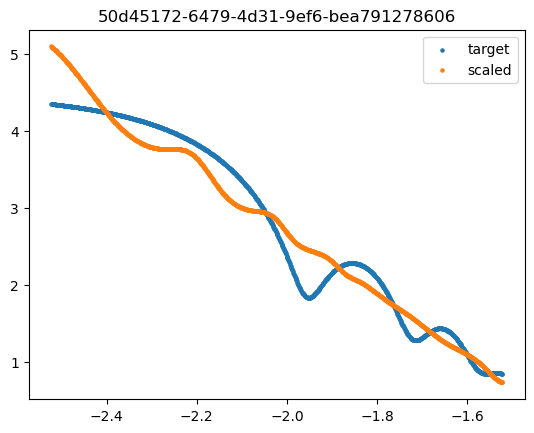

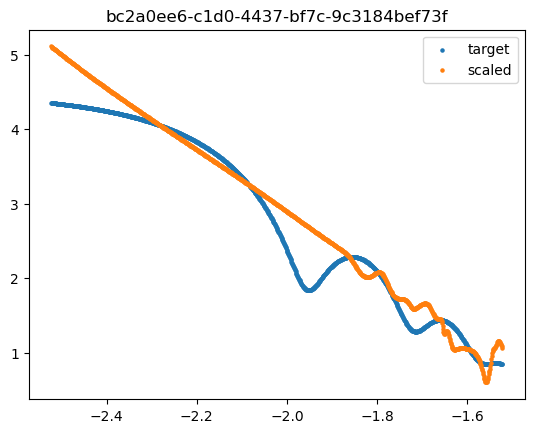

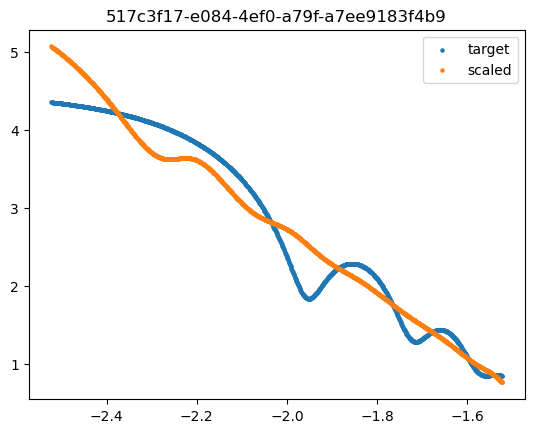

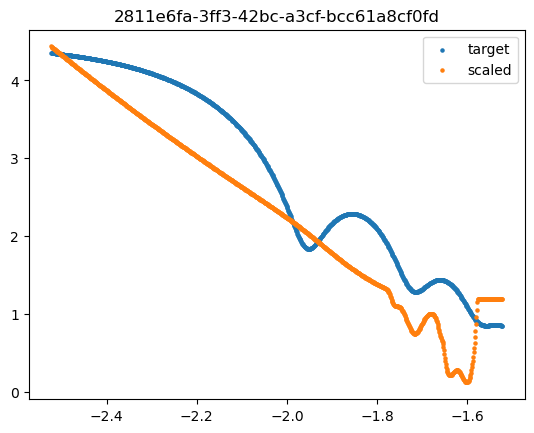

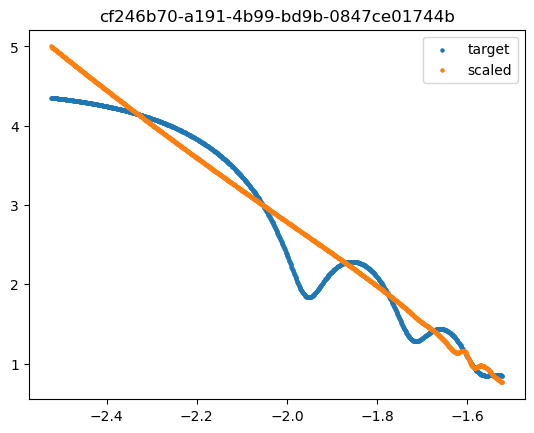

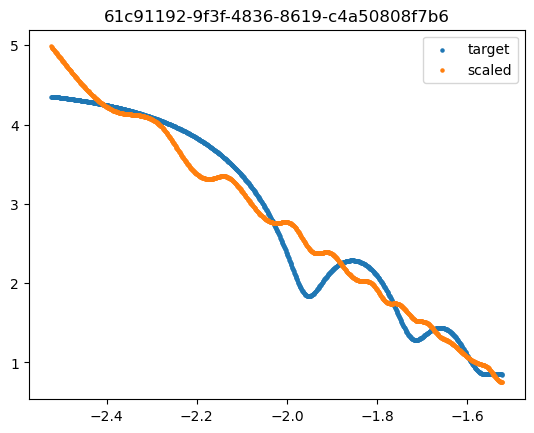

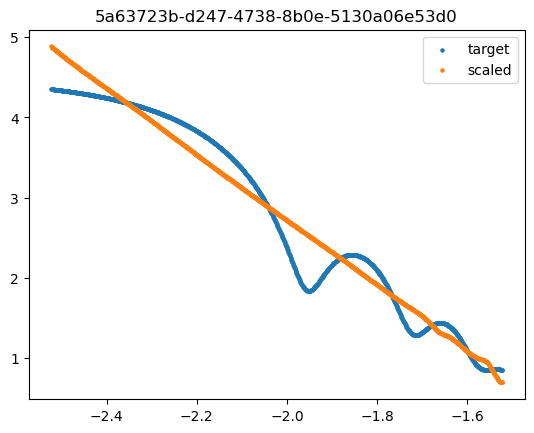

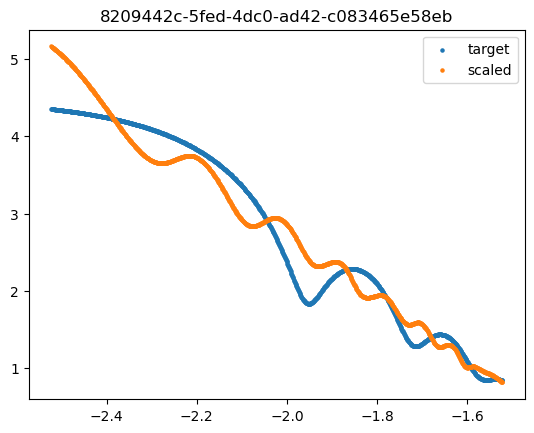

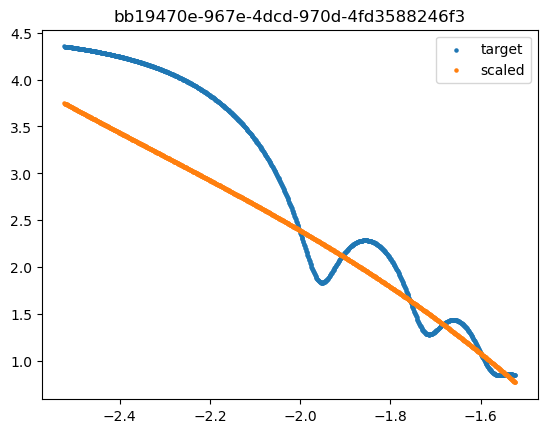

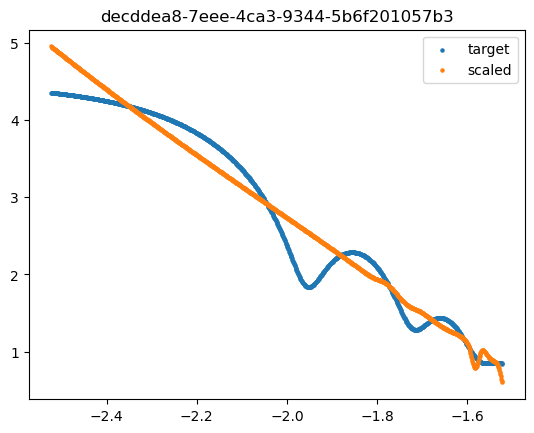

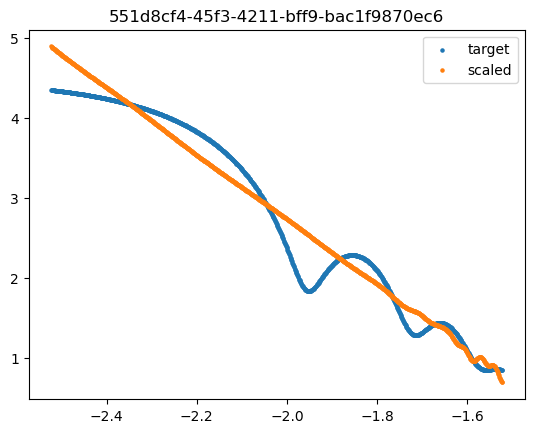

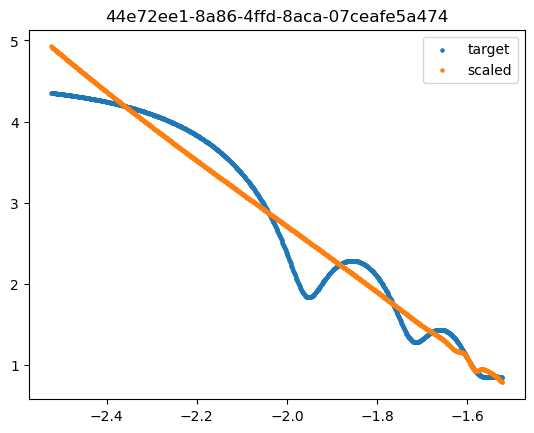

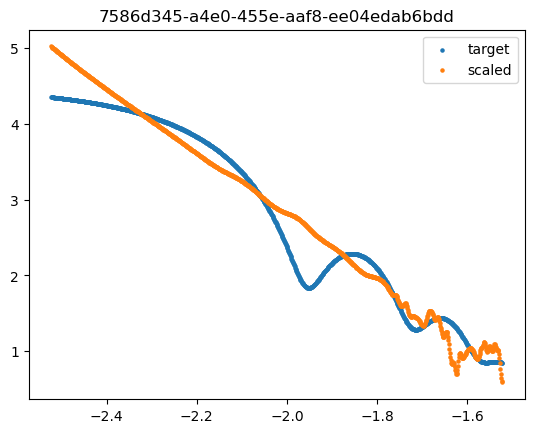

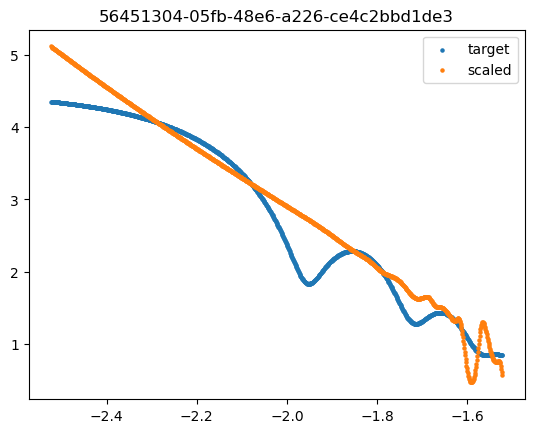

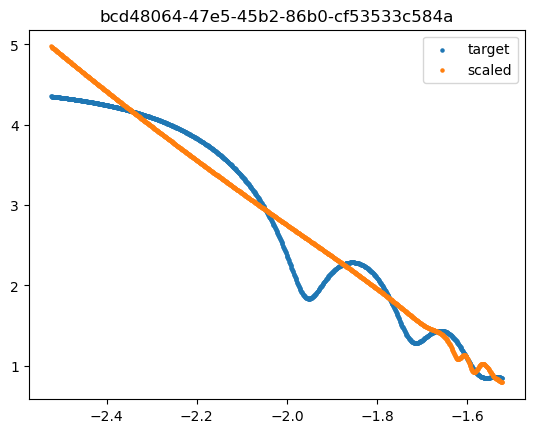

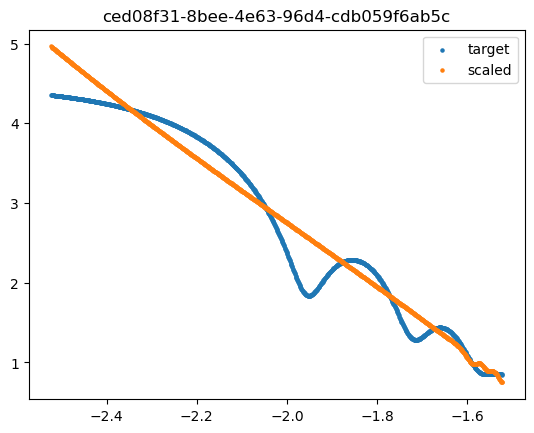

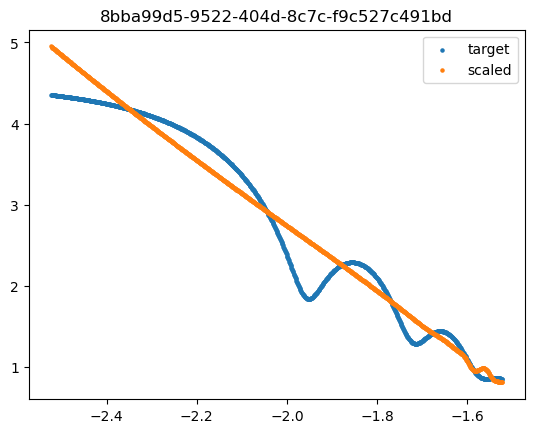

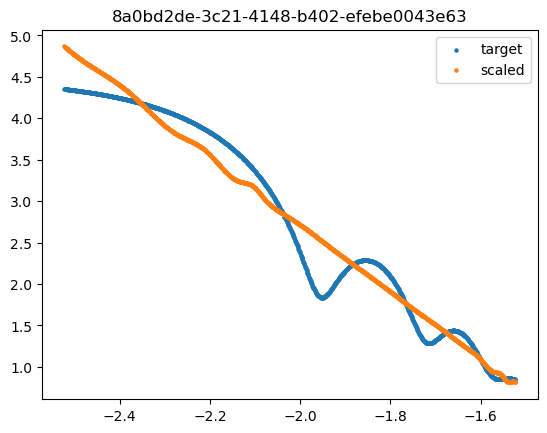

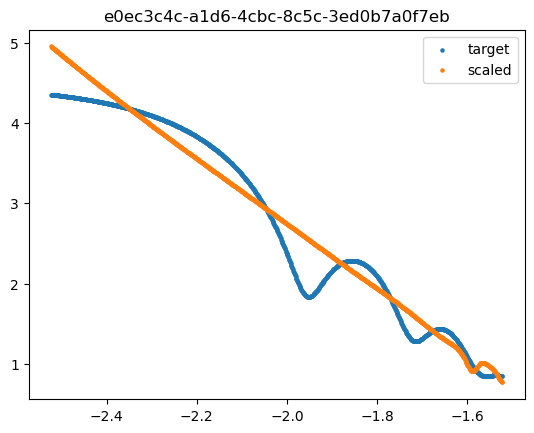

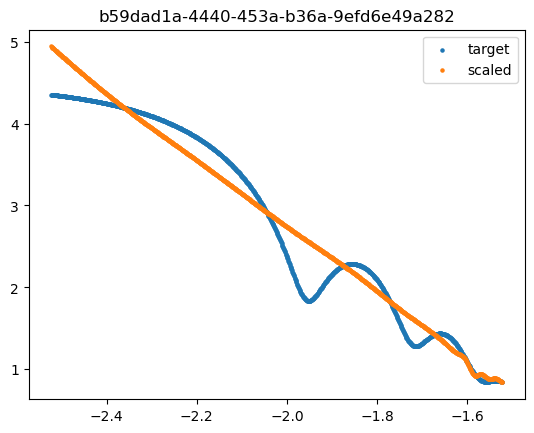

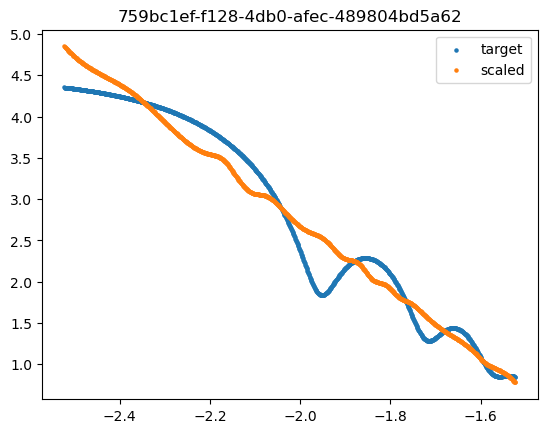

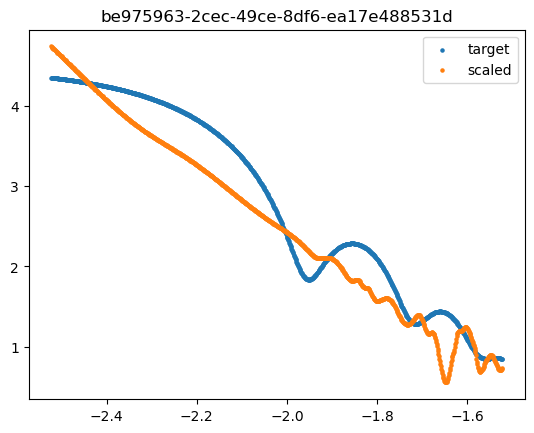

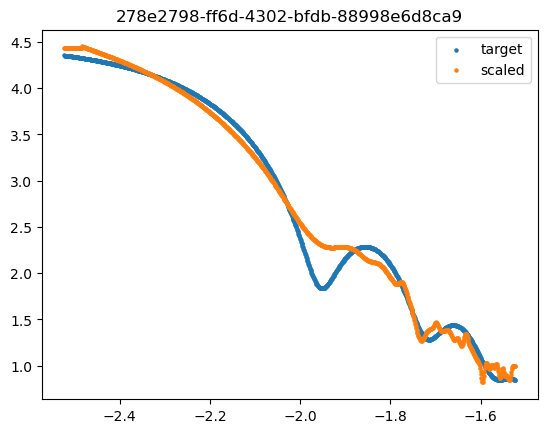

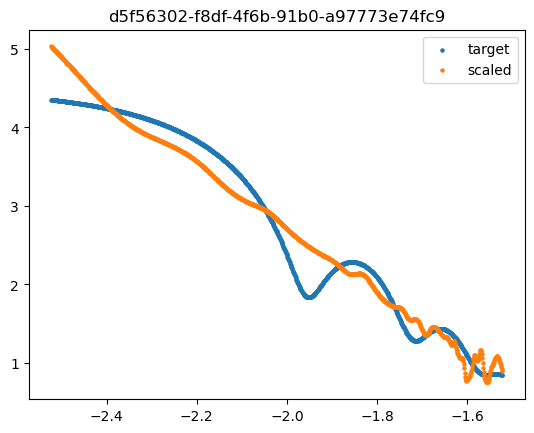

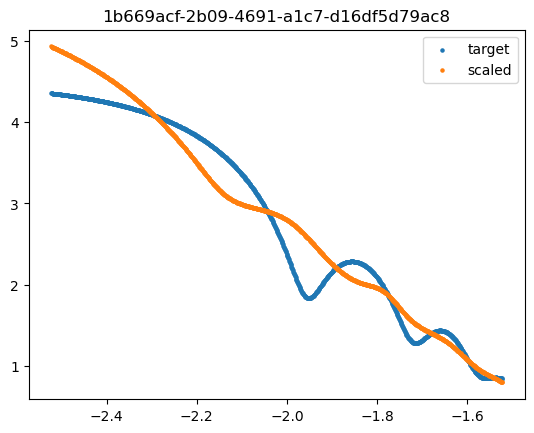

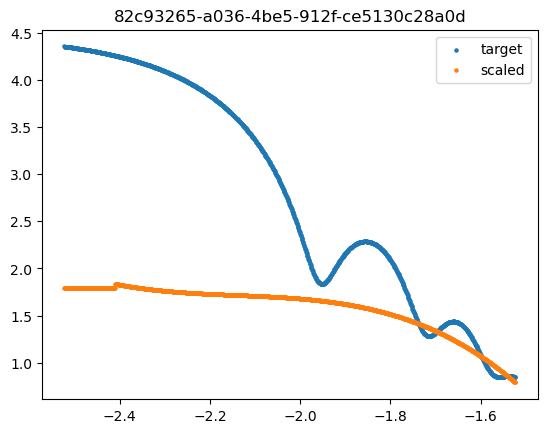

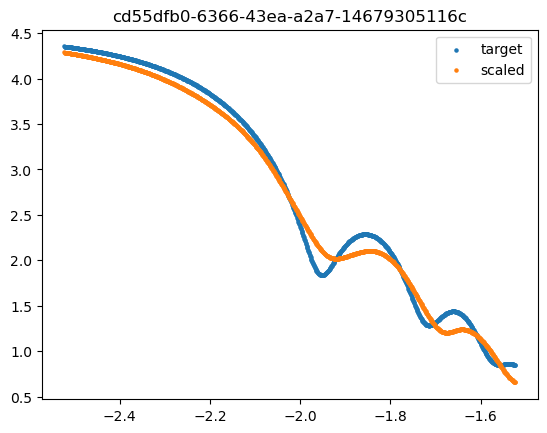

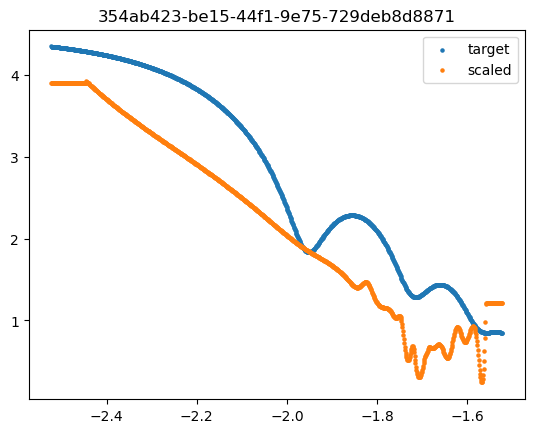

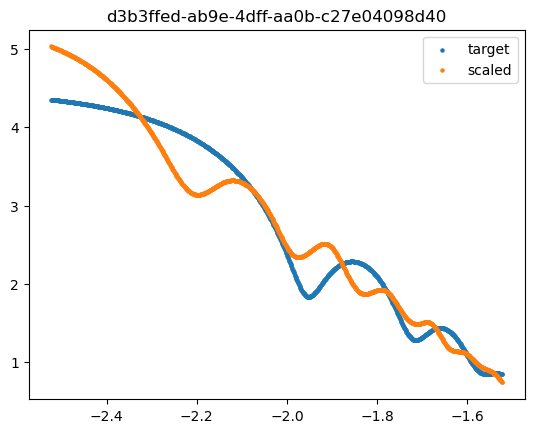

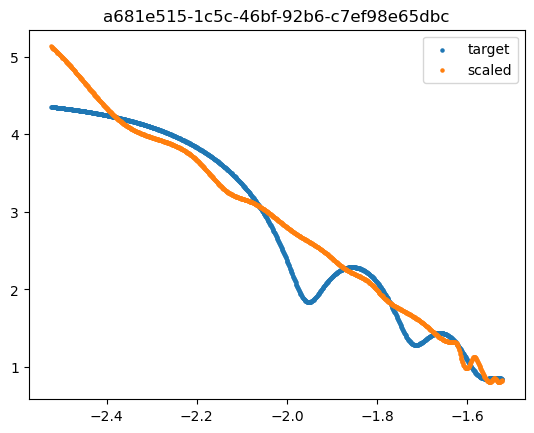

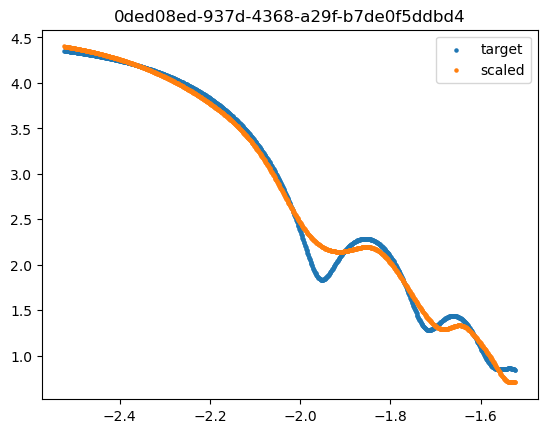

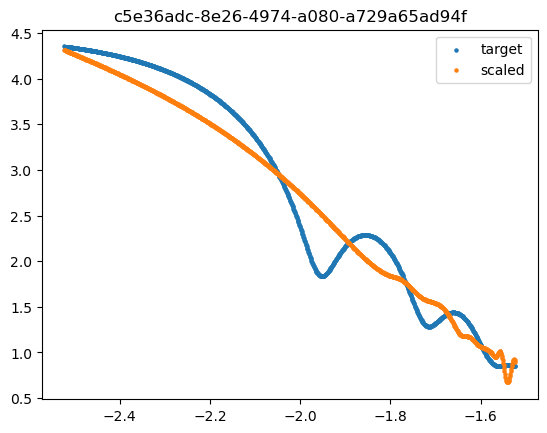

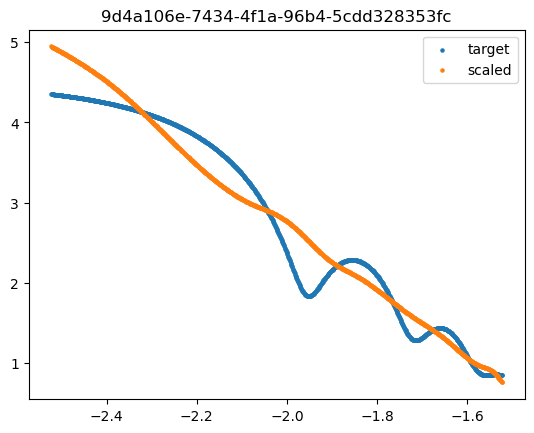

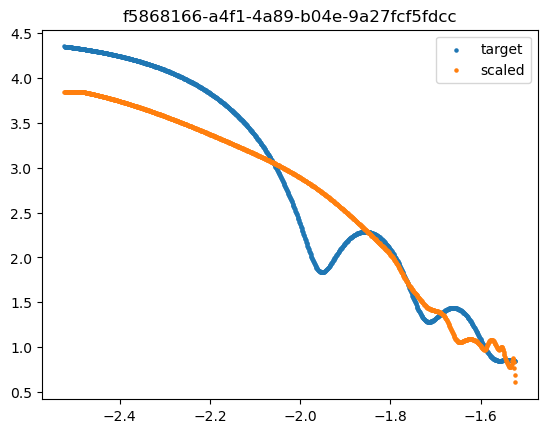

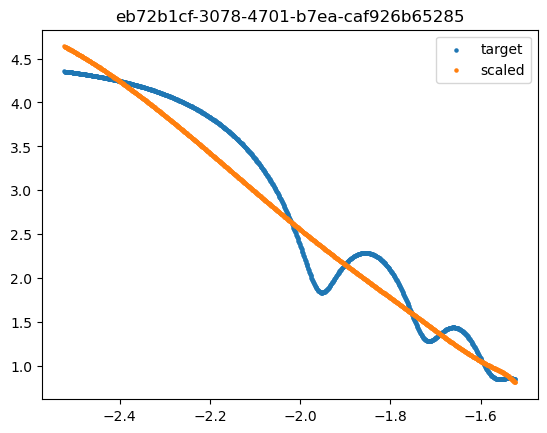

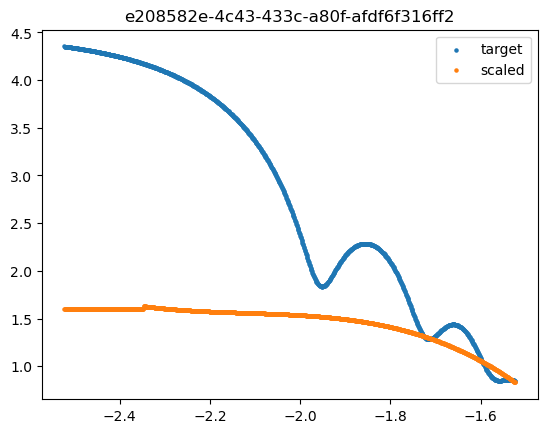

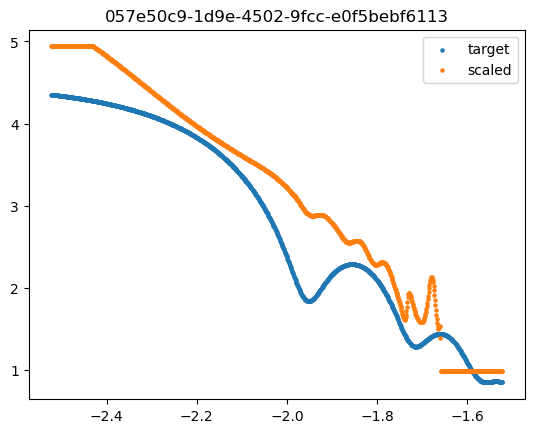

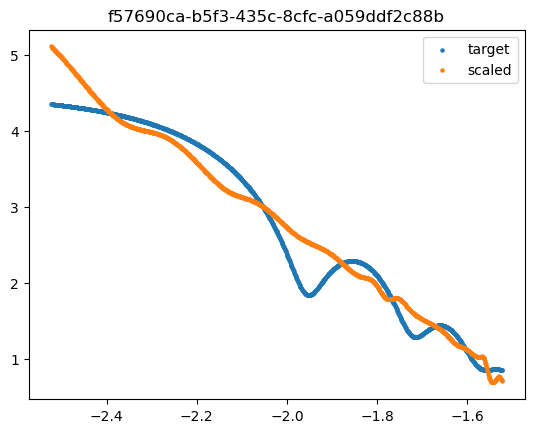

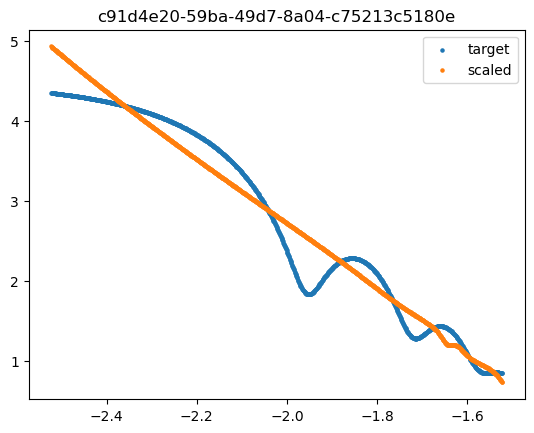

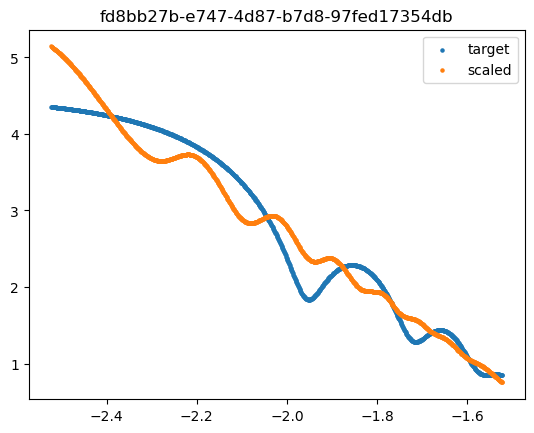

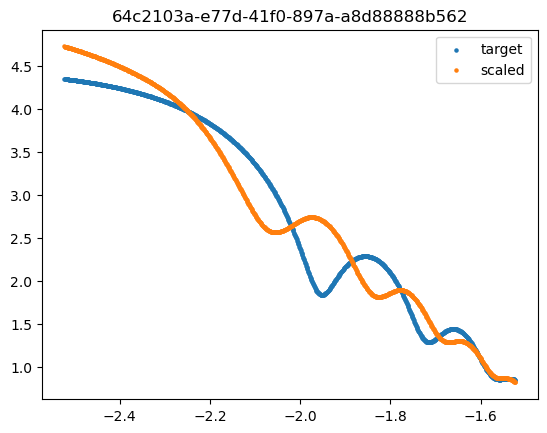

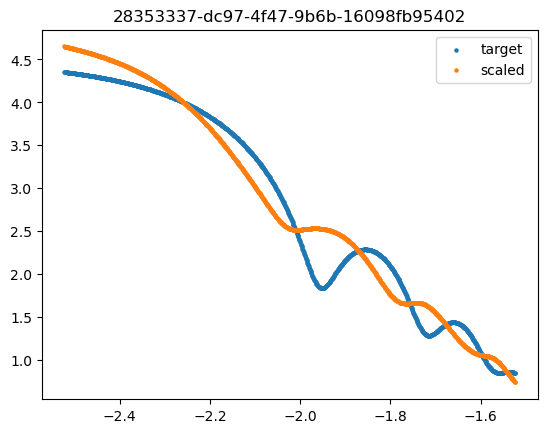

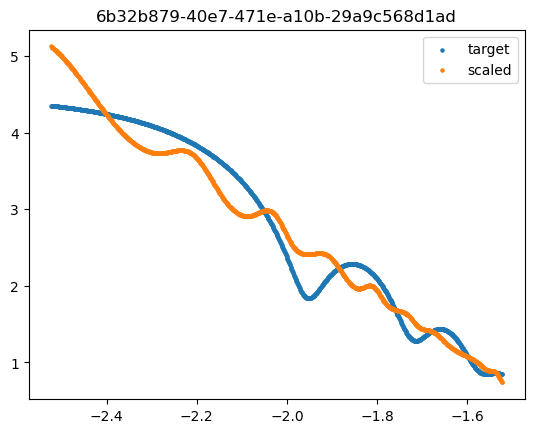

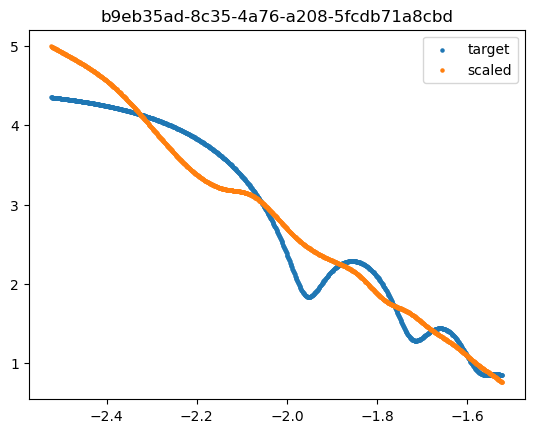

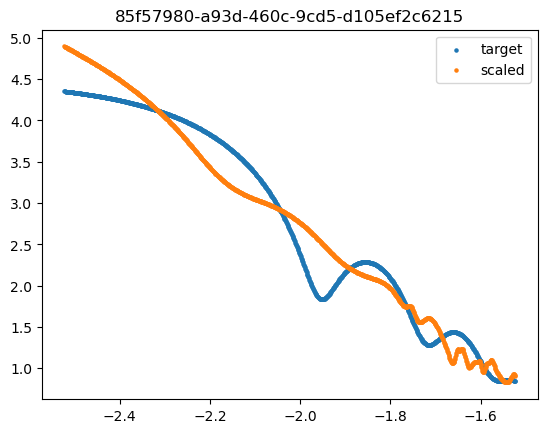

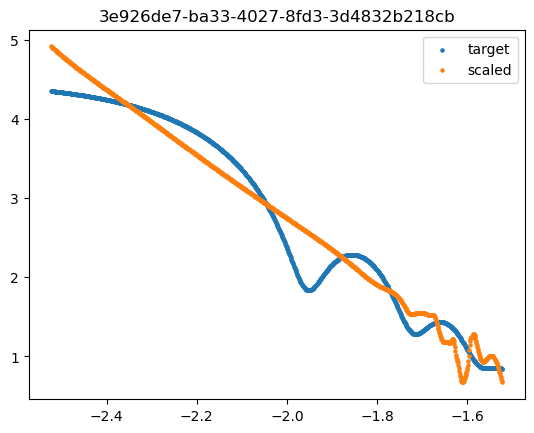

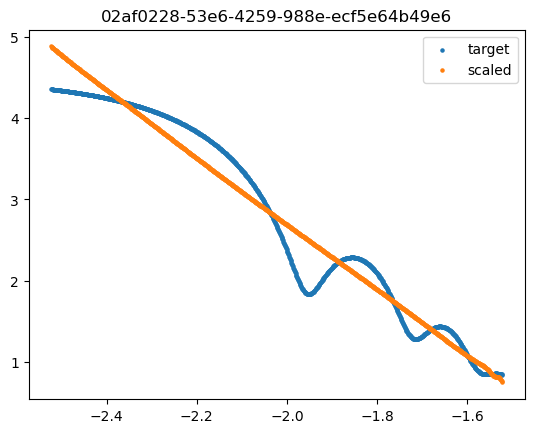

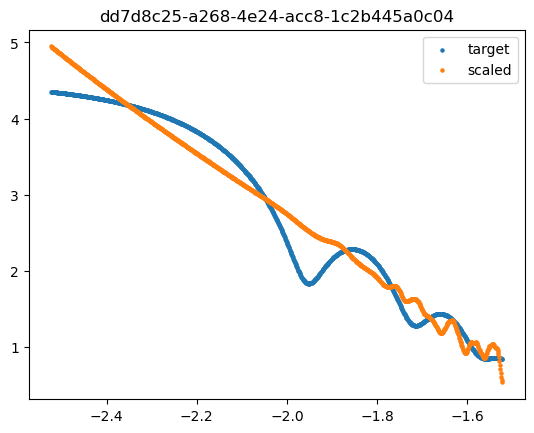

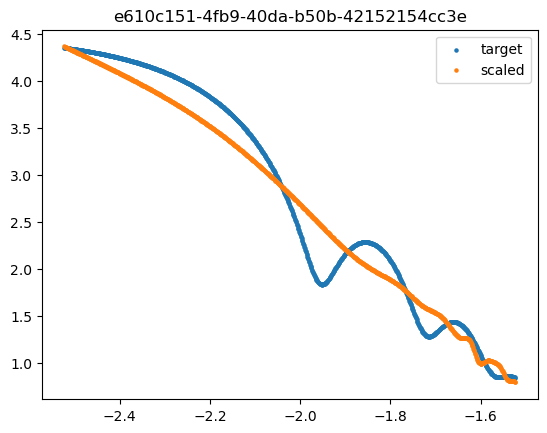

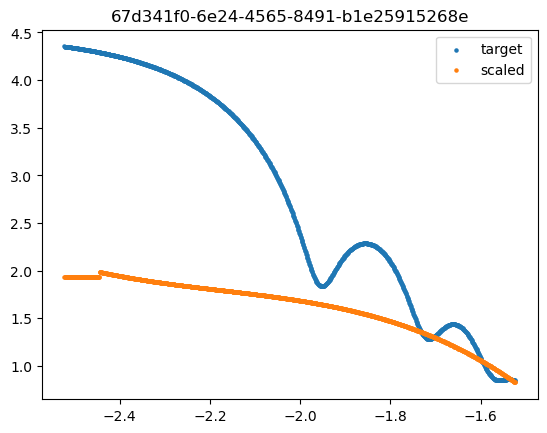

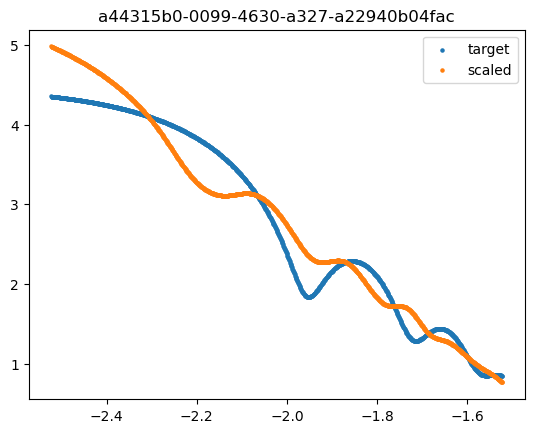

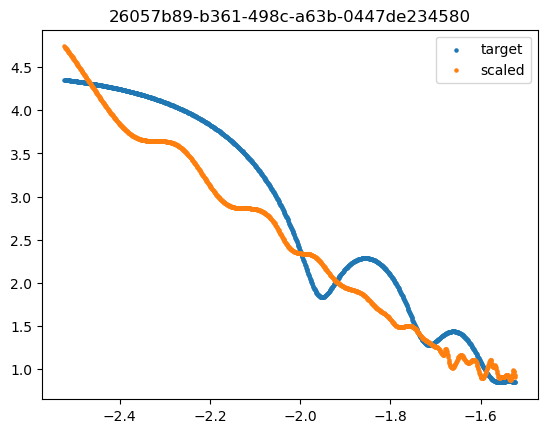

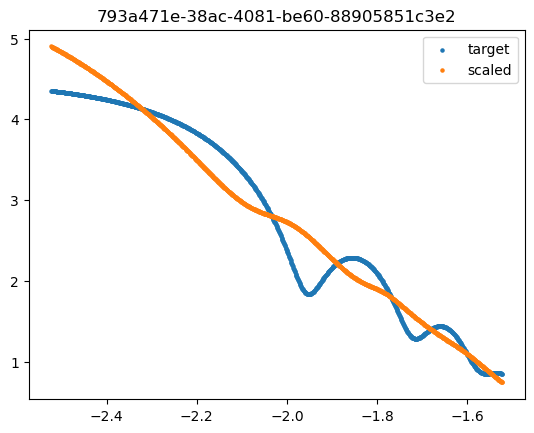

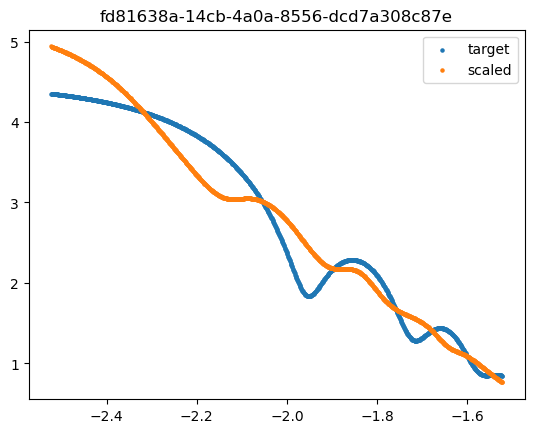

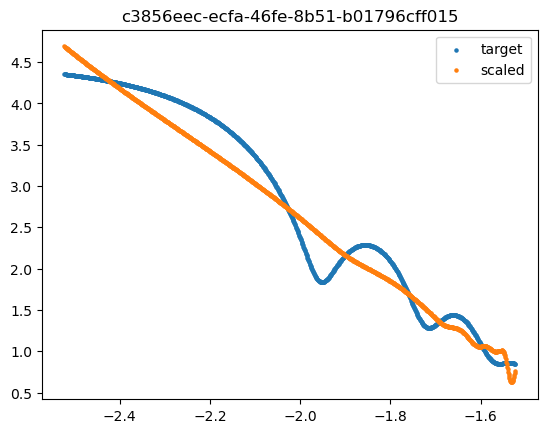

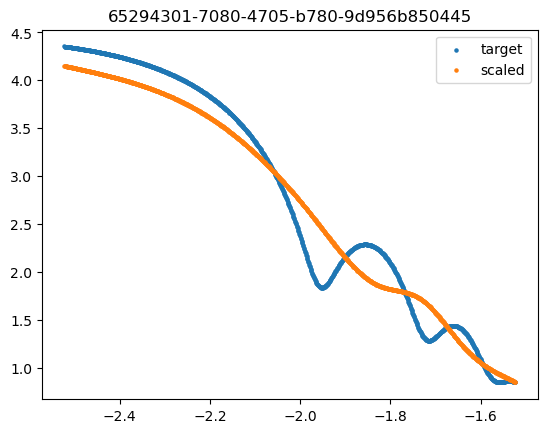

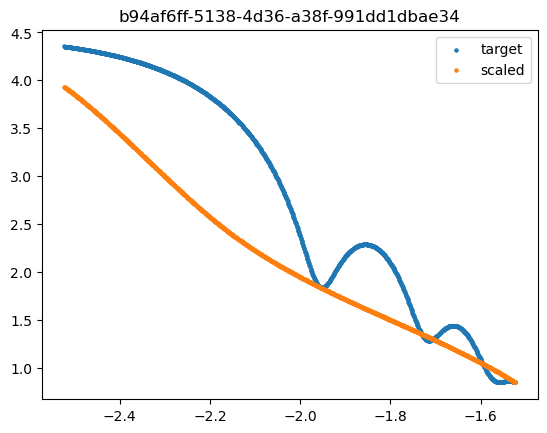

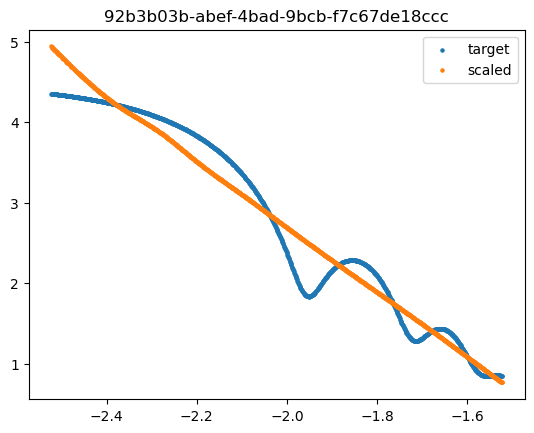

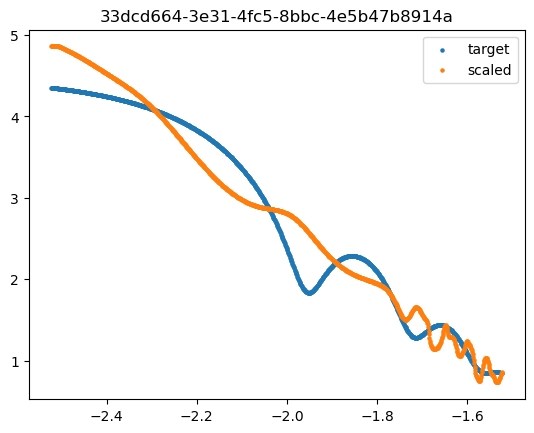

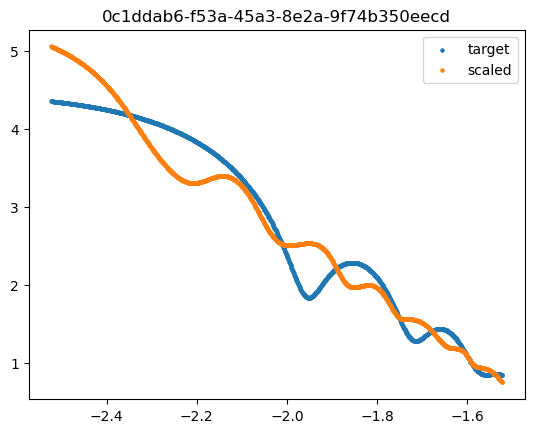

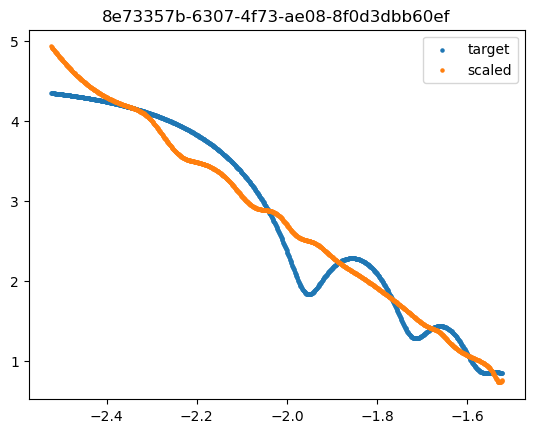

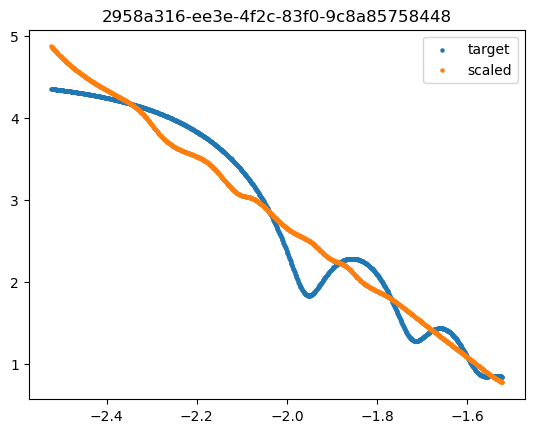

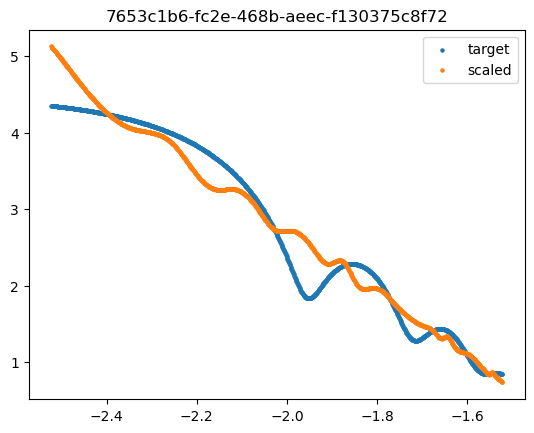

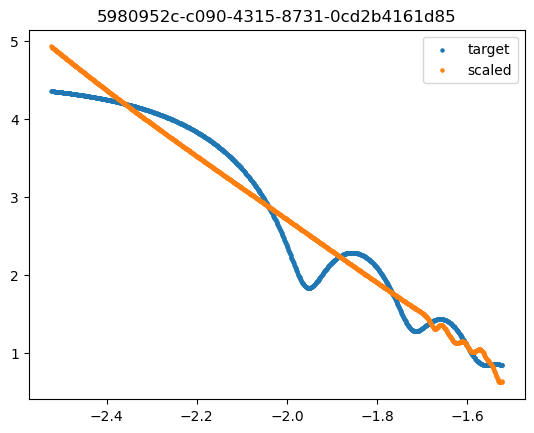

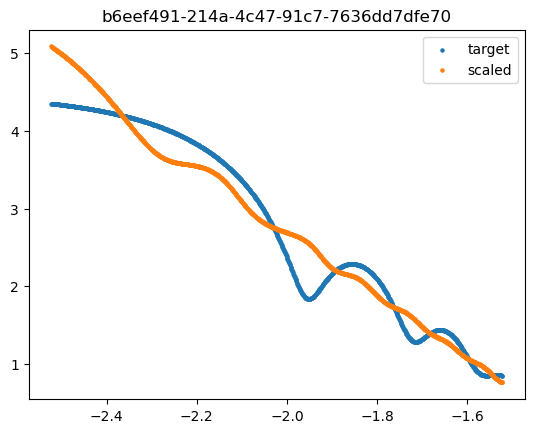

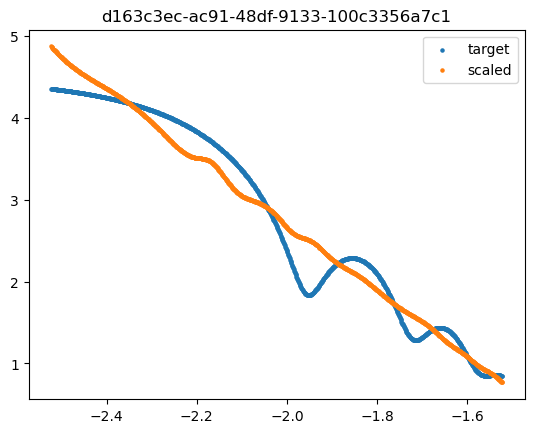

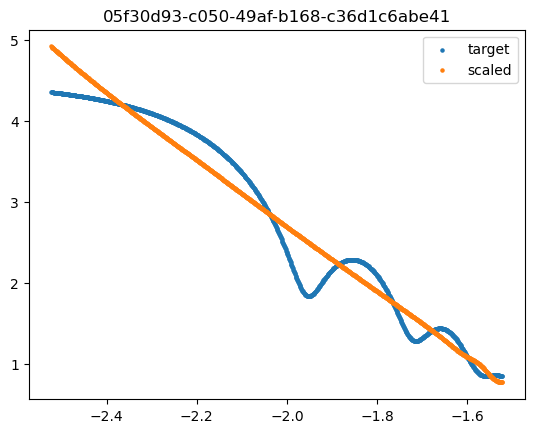

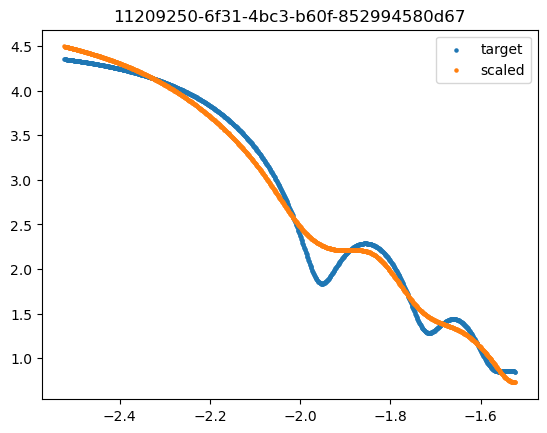

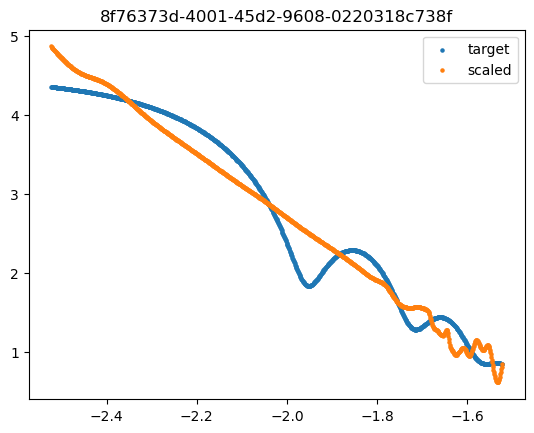

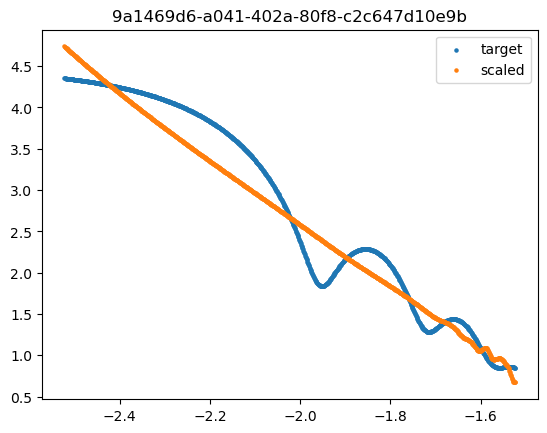

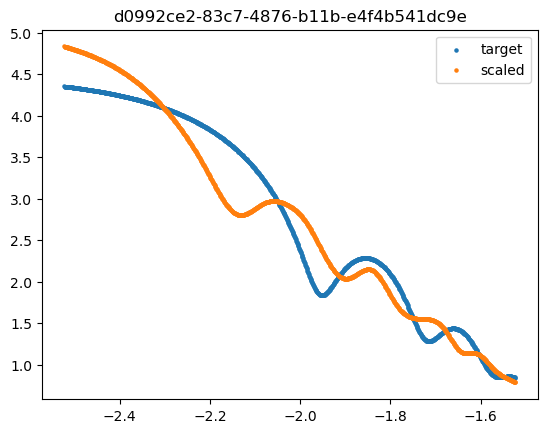

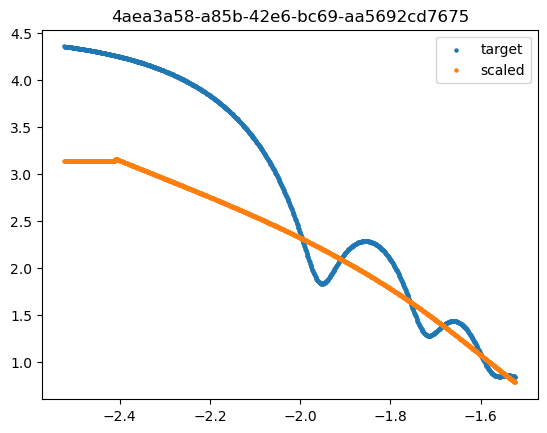

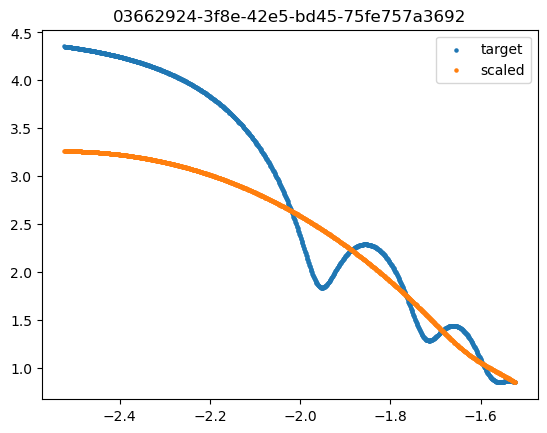

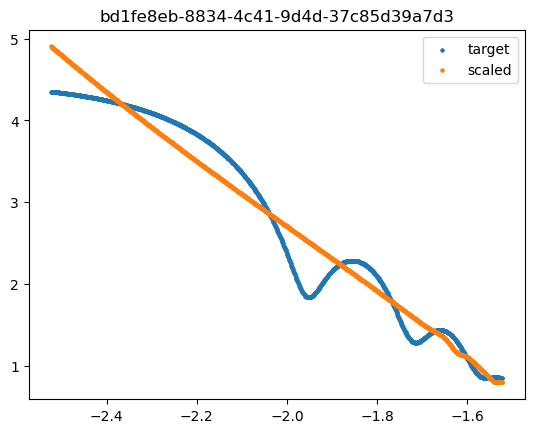

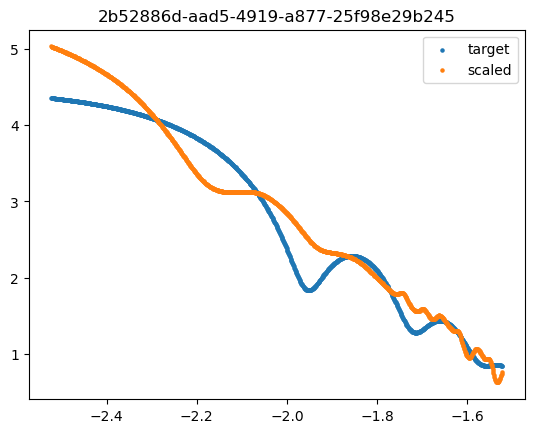

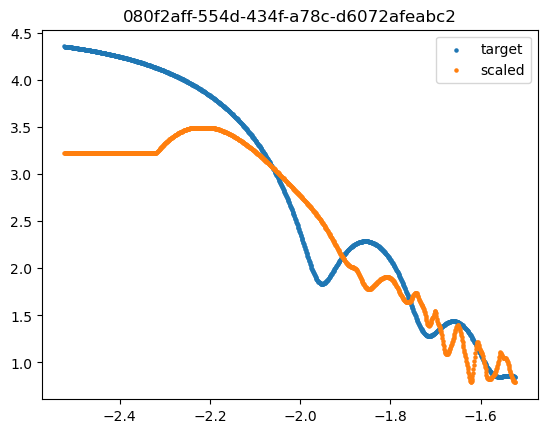

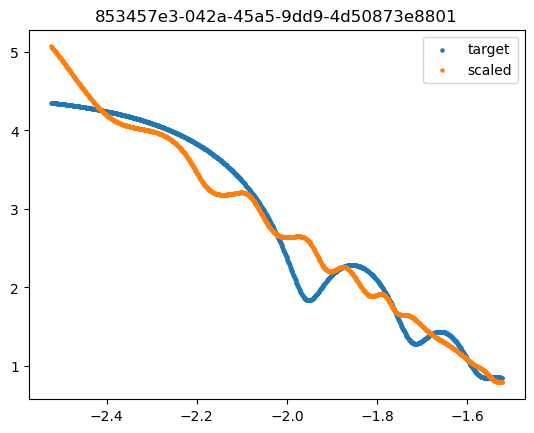

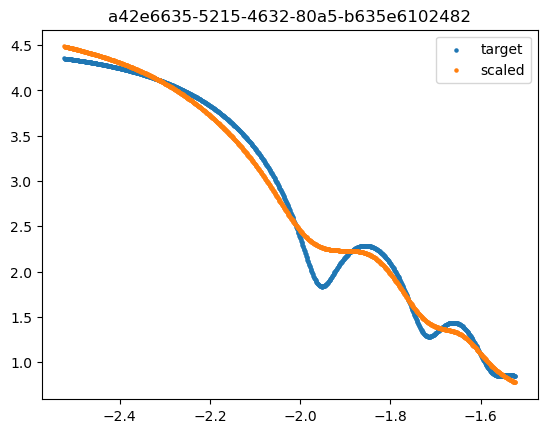

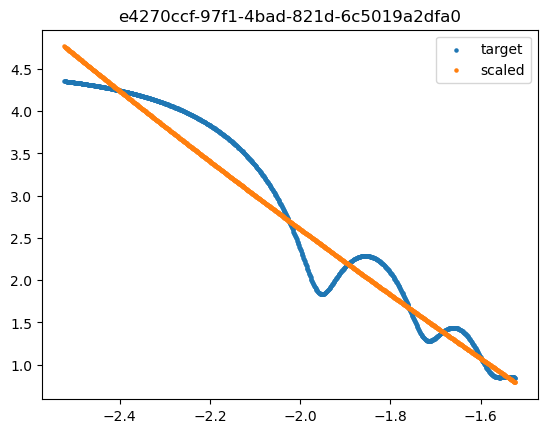

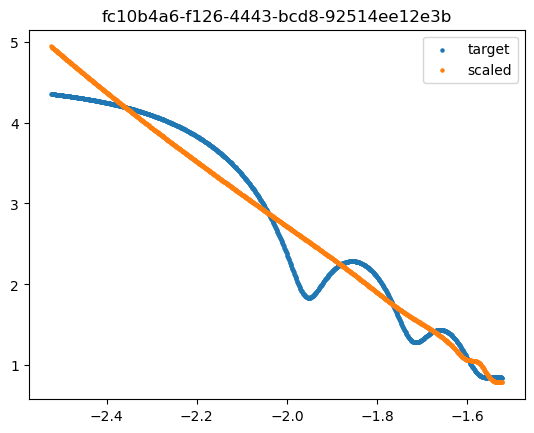

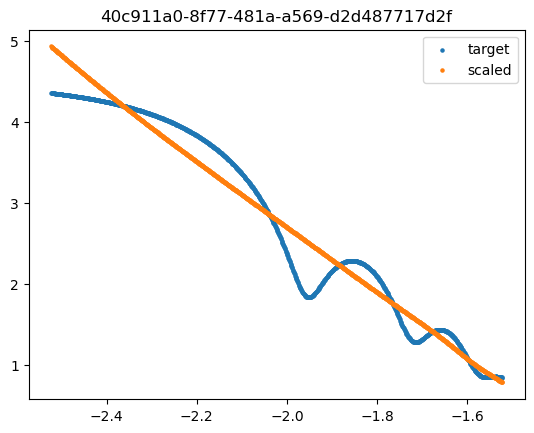

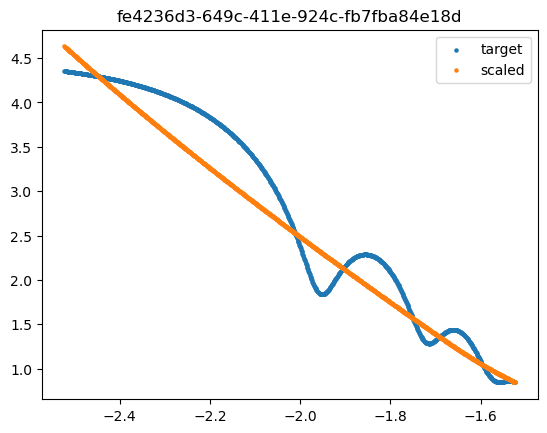

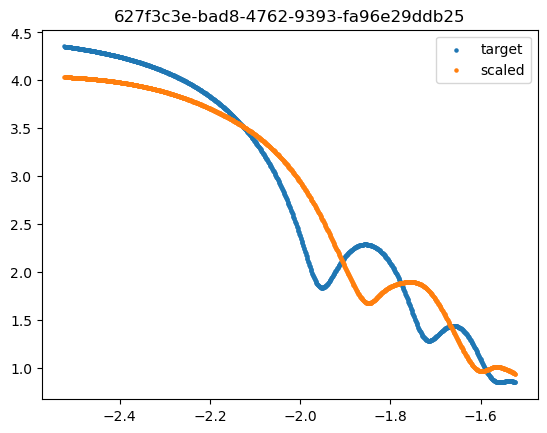

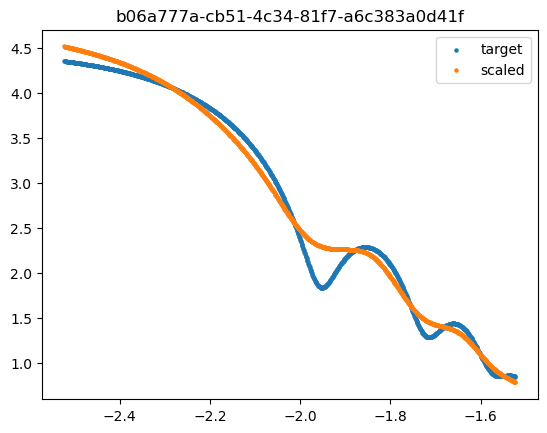

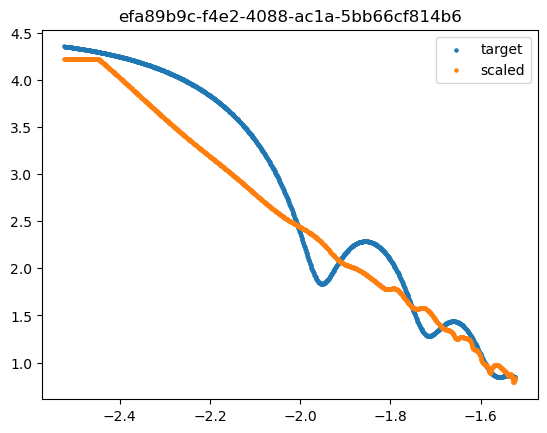

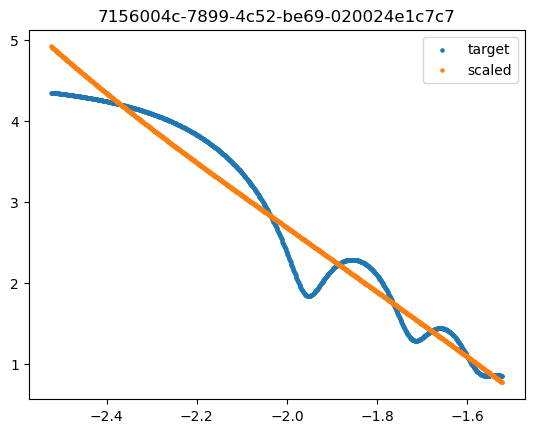

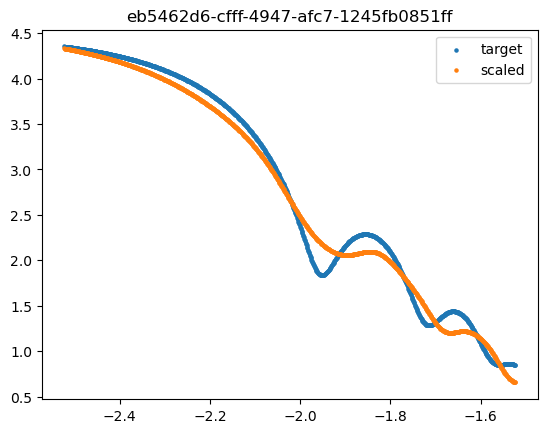

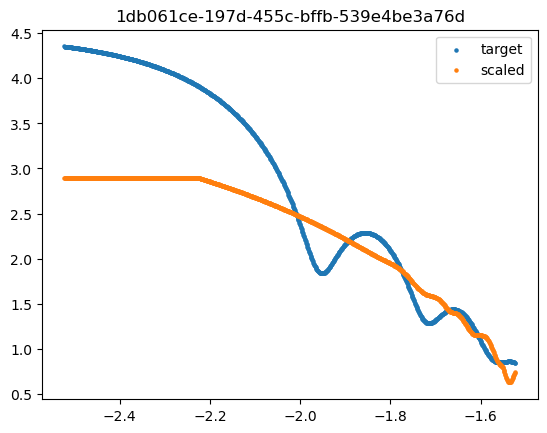

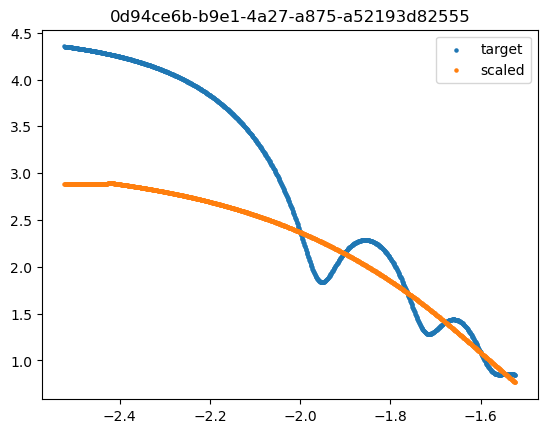

In [14]:
for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            continue
        else:
            raise KeyError
    except KeyError:
        fig, ax = plt.subplots()


        I_scaled = entry['I_scaled']
        
    
        ax.scatter(q_grid, target_I, label = 'target', s = 5)
        ax.scatter(q_grid, I_scaled, label = 'scaled', s = 5)
        ax.legend()
        ax.set_title(uuid_val)

## Fit sphere model

In [17]:
for uuid_val, entry in processing_dataset.items():
    try:
        subtracted = entry['subtracted_clipped']
    except KeyError:
        continue
        
    data_sas = io.df_to_sasdata(subtracted)
    results, result_obj, problem  = sasview_fitting.fit_sphere(data_sas, polydispersity=True, r_init=50, pd_init = 0, pd_distribution='lognormal')

    processing_dataset[uuid_val]['sphere_fit_results'] = results
    processing_dataset[uuid_val]['sphere_fit_problem'] = problem

In [18]:
diameters = {}
pdi_vals = {}

for uuid_val, entry in processing_dataset.items():
    try:
        sphere_results = entry['sphere_fit_results']
        d = sphere_results['radius']*2/10
        pdi = sphere_results['radius_pd']
        diameters[uuid_val] = d
        pdi_vals[uuid_val] = pdi
    except KeyError:
        continue

## sanity check fit results

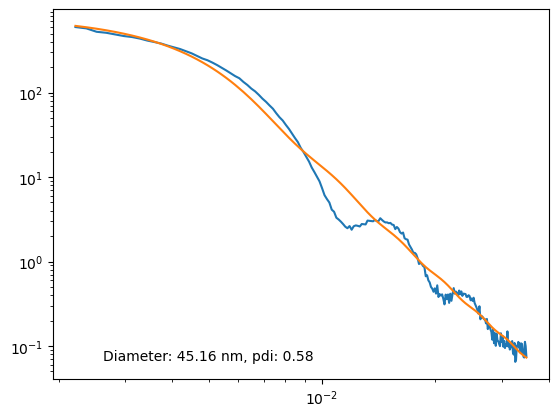

In [19]:
for uuid_val, entry in processing_dataset.items():
    try:
        sphere_d = entry['sphere_fit_results']['radius']*2/10
        sphere_pdi = entry['sphere_fit_results']['radius_pd']
    
        problem = entry['sphere_fit_problem']
    except KeyError:
        continue


    data = problem.fitness._data
    Icalc = problem.fitness.Iq_calc

    fig, ax = plt.subplots()

    ax.loglog(data.x, data.y, label = 'measured')
    ax.loglog(data.x, Icalc, label = 'fit')
    ax.text(0.1, 0.05, f'Diameter: {sphere_d:.2f} nm, pdi: {sphere_pdi:.2f}', transform = ax.transAxes)

## Write results to disk

In [18]:
uuid_vals = []
amplitude = []
phase = []
sum_ap = []
raw_rmse = []
statuses = []
sphere_diameter = []
sphere_pdi = []

for uuid_val, entry in processing_dataset.items():
    try:
        status = entry['status']
        if status == 'failed':
            uuid_vals.append(uuid_val)
            amplitude.append(None)
            phase.append(None)
            sum_ap.append(None)
            statuses.append('failed')
            sphere_diameter.append(None)
            sphere_pdi.append(None)
            raw_rmse.append(None)
            continue
        else:
            raise KeyError
    except KeyError:
        uuid_vals.append(uuid_val)
        amplitude.append(entry['amplitude_distance'])
        phase.append(entry['phase_distance'])
        sum_ap.append(entry['ap_sum_distance'])
        raw_rmse.append(entry['rmse_raw'])
        statuses.append('success')
        sphere_diameter.append(entry['sphere_fit_results']['radius']*2/10)
        sphere_pdi.append(entry['sphere_fit_results']['radius_pd'])
    

In [19]:
results_df = pd.DataFrame({'uuid':uuid_vals, 'amplitude_distance':amplitude, 'phase_distance':phase, 'sum_ap_distance':sum_ap, 'raw_rmse_distance':raw_rmse, 'sphere_diameter_nm':sphere_diameter, 'sphere_pdi':sphere_pdi, 'processes_status':statuses})

In [20]:
results_df.to_csv('distance_results_comparisonOptRound2_80nm_postprocess.csv')

In [21]:
results_df

uuid  amplitude_distance  phase_distance  \
0    4bec4e18-80bb-44d9-8508-cc464f14b287            0.746509        0.546916   
1    a180d359-a229-4b3e-a615-2991fd549f42            0.801114        0.543067   
2    3584700a-8b01-4e59-a53a-1300fd3fac0a            0.866996        0.549924   
3    0e6edb88-77c3-4984-a38d-198341bba9e1            0.840929        0.578464   
4    68831f53-4a51-4f12-b385-10c50c8fab46            0.985176        0.528511   
..                                    ...                 ...             ...   
155  7156004c-7899-4c52-be69-020024e1c7c7            1.027260        0.516236   
156  eb5462d6-cfff-4947-afc7-1245fb0851ff            0.584084        0.230432   
157  1db061ce-197d-455c-bffb-539e4be3a76d            1.082676        0.540105   
158  0d94ce6b-b9e1-4a27-a875-a52193d82555            1.193500        0.438291   
159  58c36940-4c76-4e8d-bc15-ff110d639176                 NaN             NaN   

     sum_ap_distance  raw_rmse_distance  sphere_diameter_nm  sphere_pdi  \
0           1.293424           0.263329           73.262381    1.000000   
1           1.344181           0.261322          100.922977    0.722970   
2           1.416920           0.258173           96.631829    0.704364   
3           1.419393           0.271926           93.463489    0.718000   
4           1.513687           0.267274           94.828557    0.695253   
..               ...                ...                 ...         ...   
155         1.543496           0.267654           88.714086    1.000000   
156         0.814515           0.134620           77.290132    0.167787   
157         1.622781           0.802155          234.571079    0.092514   
158         1.631792           0.848379           19.600508    0.535364   
159              NaN                NaN                 NaN         NaN   

    processes_status  
0            success  
1            success  
2            success  
3            success  
4            success  
..               ...  
155          success  
156          success  
157          success  
158          success  
159           failed  

[160 rows x 8 columns]

## Split rmse and apdist samples



In [40]:
synthesis_files = ['/home/bgpelkie/Code/silica-np-synthesis/2024_10_04_RandomBaseline_v2/Sample_table_2024_10_04_randomsampleV2.csv', 
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_10_07_randomSampleV3/Sample_table_2024_10_07_randomsampleV3.csv', 
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_10_17_RandomBaselineV4/Sample_table_2024_10_17_RandomBaselineV4.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_apdist.csv',
                   '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_rmsedist.csv'] 

In [41]:
fp2name = {'/home/bgpelkie/Code/silica-np-synthesis/2024_10_07_randomSampleV3/Sample_table_2024_10_07_randomsampleV3.csv':'2024_10_07_randomSampleV3', 
           '/home/bgpelkie/Code/silica-np-synthesis/2024_10_04_RandomBaseline_v2/Sample_table_2024_10_04_randomsampleV2.csv':'2024_10_04_RandomBaseline_v2', 
           '/home/bgpelkie/Code/silica-np-synthesis/2024_10_17_RandomBaselineV4/Sample_table_2024_10_17_RandomBaselineV4.csv':'2024_10_17_RandomBaselineV4',
           '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_apdist.csv':'2024_12_16_Optimize_APdist',
           '/home/bgpelkie/Code/silica-np-synthesis/2024_12_16_DistCompare_80nmTarget_round1/Sample_table_2024_12_16_CompareOpt_80nmTarget_Round1_rmsedist.csv':'2024_12_16_Optimize_rmse'
          }



In [42]:
random_files = ['2024_10_07_randomSampleV3', '2024_10_04_RandomBaseline_v2', '2024_10_17_RandomBaselineV4']
apdist_files = ['2024_12_16_Optimize_APdist']
rmse_files = ['2024_12_16_Optimize_rmse']

In [44]:
synth_tables = []

random_uuids = []
apdist_uuids = []
rmse_uuids = []

count = 0
for fp in synthesis_files:
    data= pd.read_csv(fp)
    name = fp2name[fp]
    data['campaign'] = [name]*len(data)
    synth_tables.append(data)
    count += len(data)
    if name in random_files:
        random_uuids.extend(list(data['uuid']))
    if name in apdist_files:
        apdist_uuids.extend(list(data['uuid']))
    if name in rmse_files:
        rmse_uuids.extend(list(data['uuid']))
        
    

synth_table = pd.concat(synth_tables, axis = 0)

In [45]:
apdist_samples = random_uuids.copy()
apdist_samples.extend(apdist_uuids)

rmse_samples = random_uuids.copy()
rmse_samples.extend(rmse_uuids)

## Plot final ranked order of best samples APdist

In [46]:
sum_ap = {}
for uuid_val, entry in processing_dataset.items():
    if uuid_val in apdist_samples:
        try:
            
            status = entry['status']
            if status == 'failed':
                continue
            else:
                raise KeyError
                
        except KeyError:
            sum_ap[uuid_val] = entry['ap_sum_distance']
    else:
        continue


uuids = np.array(list(sum_ap.keys()))
rmses = list(sum_ap.values())
uuid_sorted_sum = uuids[np.argsort(rmses)]

In [47]:

with PdfPages('ranked_apdist_results.pdf') as pdf:
    for i, uuid_val in enumerate(uuid_sorted_sum):

        entry  = processing_dataset[uuid_val]
        I_scaled = entry['I_scaled']
        
        distance = sum_ap[uuid_val]

        sphere_d = entry['sphere_fit_results']['radius']*2/10
        sphere_pdi = entry['sphere_fit_results']['radius_pd']


    
        fig, ax = plt.subplots()
        ax.loglog(10**q_grid, 10**target_I, label = 'target')
        ax.loglog(10**q_grid, 10**I_scaled, label = 'measured')
        ax.set_xlabel('q [1/A]')
        ax.set_title(uuid_val)
        ax.text(0.1, 0.1, f'Rank: {i}\nsum distance: {distance:.2f}\nsphere diameter: {sphere_d:.2f} nm\nsphere pdi: {sphere_pdi:.2f}', transform = ax.transAxes)
        ax.legend()
        pdf.savefig()
        plt.close()

## Plot raw RMSE

In [51]:
raw_rmse = {}
for uuid_val, entry in processing_dataset.items():
    if uuid_val in rmse_samples:
        try:
            
            status = entry['status']
            if status == 'failed':
                continue
            else:
                raise KeyError
                
        except KeyError:
            raw_rmse[uuid_val] = entry['rmse_raw']
    else:
        continue


uuids = np.array(list(raw_rmse.keys()))
rmses = list(raw_rmse.values())
uuid_sorted_rmseraw = uuids[np.argsort(rmses)]

In [52]:
with PdfPages('ranked_rawrmse_results.pdf') as pdf:
    for i, uuid_val in enumerate(uuid_sorted_rmseraw):

        entry  = processing_dataset[uuid_val]
        I_scaled = entry['I_scaled']
        
        distance = raw_rmse[uuid_val]

        sphere_d = entry['sphere_fit_results']['radius']*2/10
        sphere_pdi = entry['sphere_fit_results']['radius_pd']


    
        fig, ax = plt.subplots()
        ax.loglog(10**q_grid, 10**target_I, label = 'target')
        ax.loglog(10**q_grid, 10**I_scaled, label = 'measured')
        ax.set_xlabel('q [1/A]')
        ax.set_title(uuid_val)
        ax.text(0.1, 0.1, f'Rank: {i}\nrmse_raw distance: {distance:.2f}\nsphere diameter: {sphere_d:.2f} nm\nsphere pdi: {sphere_pdi:.2f}', transform = ax.transAxes)
        ax.legend()
        pdf.savefig()
        plt.close()